## Introduction to Large Language Models (LLMs)

This notebook provides a foundational understanding of Large Language Models (LLMs) by exploring their core mechanics. Everything we will walk through is exactly how LLMs work, but on a much smaller scale. After learning how they work, we will train a tiny LLM on some sample data.

Throughout this exploration keep in mind that AI models are just big math equations that model some system or relationship by mapping an input to an output.

In the case of LLMs, we are modeling the process of producing an appropriate next word/token given an input sequence.

Run the cell below to import the necessary libraries and let's begin.

In [ ]:
# Master Imports Cell
import random
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import urllib.request

random.seed(1738)

---


## **Tokens in LLMs**

In LLMs, text is **not** processed directly as raw characters or full words. Instead, it's broken down into smaller units called **tokens**. Tokens are units of language that can be arranged to form any text input.

A token can be a word, a part of a word (subword), a punctuation mark, etc... For example, the sentence "What's the weather?" might be tokenized into `["What", "'s", " the", "wea", "ther", "?"]`.

#### **Why are Tokens Used?**

Processing text at the character level lets us represent any sequence of text, but is computationally expensive and creates very long sequences. Processing at the word level is simpler, but requires a representation for every word the model could potentially see. Breaking words into subwords is a middle ground that provides the flexibility of character level-representations and the simplicity of word-level representations without the issues they both present.


The set of unique tokens that a model is trained on is called its vocabulary. Vocabulary size varies between models, but typically falls in the range of 100,000 to 150,000 for state of the art LLMs. The choice of vocabulary size is a trade-off: a larger vocabulary can represent more words directly, leading to shorter sequences, but it also increases the model's complexity and memory footprint.

#### **For our model, we will assume a tiny vocabulary size of only 20. Our input text will be some combination of these 20 tokens, and our output will be the best choice of these 20 tokens given our input.**

For simplicity, our input will only be two tokens and we will treat whole words as tokens. Run the cell below and pick your two word input.

In [ ]:
vocab = ['cat', 'is', 'happy', 'the', 'fast', 'dog', 'runs', 'a', 'tree', 'small', 'sits', 'car', 'went', 'big', 'sleeps', 'cold', 'red', 'house', 'was', 'eats']
random.shuffle(vocab)

print("Vocabulary:")
print(", ".join(vocab))
print("\nPlease select two tokens from the dropdown menus below:")

token_1 = vocab[0]
token_2 = vocab[0]

dropdown_1 = widgets.Dropdown(options=vocab, value=vocab[0], description='Token 1:')
dropdown_2 = widgets.Dropdown(options=vocab, value=vocab[0], description='Token 2:')

selection_output = widgets.Label()

def update_tokens(change):
    global token_1, token_2
    token_1 = dropdown_1.value
    token_2 = dropdown_2.value
    selection_output.value = f"You have chosen '{token_1}' and '{token_2}' as your input sequence."

dropdown_1.observe(update_tokens, names='value')
dropdown_2.observe(update_tokens, names='value')

display(dropdown_1, dropdown_2, selection_output)

selection_output.value = f"You have chosen '{token_1}' and '{token_2}' as your input sequence."

Vocabulary:
was, cat, small, sleeps, eats, dog, fast, tree, house, is, runs, went, cold, happy, car, sits, a, big, the, red

Please select two tokens from the dropdown menus below:


Dropdown(description='Token 1:', options=('was', 'cat', 'small', 'sleeps', 'eats', 'dog', 'fast', 'tree', 'hou…

Dropdown(description='Token 2:', options=('was', 'cat', 'small', 'sleeps', 'eats', 'dog', 'fast', 'tree', 'hou…

Label(value='')

---

## **Token IDs**

Computers only understand numbers. Before a language model can process our tokens, they must be converted into numerical values called **Token IDs**.

A token ID is a unique integer assigned to each token in the model's vocabulary. You can think of it as looking up a word in a dictionary and getting its index number. Since our model has a vocabulary of 20 tokens, our token IDs will range from 0 to 19.

#### **Finding our Token IDs**

To find the token IDs for the input sequence you selected, we simply need to look up their positions in our `vocab` list. Run the cell below to see the numerical IDs for your chosen tokens.

In [ ]:
token_1_id = vocab.index(token_1)
token_2_id = vocab.index(token_2)

print(f"Token: '{token_1}' -> Token ID: {token_1_id}")
print(f"Token: '{token_2}' -> Token ID: {token_2_id}")
print(f"\nYour Input Sequence IDs: [{token_1_id}, {token_2_id}]")

Token: 'a' -> Token ID: 16
Token: 'car' -> Token ID: 14

Your Input Sequence IDs: [16, 14]


---

## **Embeddings**

Now that we have our Token IDs, we need a way for the model to actually understand what these tokens *mean*. A single integer ID doesn't capture the semantic meaning, context, or relationships of a word. This is where **Embeddings** come in.

An embedding is a list of numbers (a vector) that represents the meaning of a token. Instead of just a single ID, each token is mapped to a list of values. 

#### **What do the numbers mean?**
You can think of each number in this list as the degree to which a token possesses a specific "feature" or "concept". For example, the first number in an embedding might correspond with how "positive" a word is, another how "action-oriented" a word is, or whether it relates to "animals" vs "objects". By representing our tokens as a series of these numbers, the model can understand that words with similar numbers (like "cat" and "dog") have similar meanings.

**This list of numbers is the *meaning* of the token, represented in numbers**

#### **Where do these numbers come from?**
The model doesn't start off knowing what these numbers should be for each token. **Embeddings are learned during training.** The token embeddings start off random. As the model learns to predict the next word in a sequence, it adjusts these numbers to better reflect the token's meaning.

#### **Our 8D Embeddings**
Each number in the embedding vector is the value of that token in a particular dimension. Real LLMs use very large embeddings (e.g., thousands of dimensions per token). For simplicity, we will use **8-Dimensional (8D) embeddings**. This means each token in our vocabulary of 20 tokens will be represented by a list of 8 numbers. Each number corresponds to a value in a particular dimension, which can be thought of as the degree to which the token possesses a specific feature.

Run the cell below to generate our model's embedding matrix and see what it looks like.

In [ ]:
# Let's create a random embedding matrix for our 20-token vocabulary
# Normally, these are learned during training. Here, we'll initialize them randomly.
embedding_dim = 8
vocab_size = len(vocab)
embedding_matrix = np.random.randn(vocab_size, embedding_dim).round(2)

embedding_df = pd.DataFrame(embedding_matrix, index=vocab, columns=[f"Dim_{i+1}" for i in range(embedding_dim)])
print("The Full 8D Embedding Matrix:")
display(embedding_df)

chosen_embedding_1 = embedding_matrix[token_1_id]
chosen_embedding_2 = embedding_matrix[token_2_id]

print("\n---")
print(f"This is your chosen two-token input, now represented as embeddings!")
print(f"Token 1 ('{token_1}'): {chosen_embedding_1.tolist()}")
print(f"Token 2 ('{token_2}'): {chosen_embedding_2.tolist()}")

The Full 8D Embedding Matrix:


,Dim_1,Dim_2,Dim_3,Dim_4,Dim_5,Dim_6,Dim_7,Dim_8
was,-0.89,-0.25,-0.74,-0.21,-1.63,1.44,-0.46,-0.05
cat,-0.82,-0.78,0.64,-0.29,-0.40,-0.98,-0.05,-1.02
small,0.50,-0.11,0.45,0.30,0.50,1.67,0.05,-0.49
sleeps,-0.87,0.57,-0.07,-0.18,0.27,-0.89,1.18,1.01
eats,-0.34,-0.02,0.23,-1.77,1.26,0.90,-0.26,0.90
dog,0.70,-0.25,-0.66,0.59,1.27,0.52,-2.95,0.35
fast,-0.21,0.79,0.20,0.85,-0.25,0.78,0.65,-0.99
tree,0.92,-0.03,-0.39,0.08,-0.98,-0.24,0.66,1.09
house,0.88,0.92,-0.33,0.68,-2.11,-1.01,1.38,1.19
is,-2.04,0.49,0.62,0.44,-0.16,2.07,-0.58,-0.63



---
This is your chosen two-token input, now represented as embeddings!
Token 1 ('a'): [0.6, 2.85, 0.37, 0.87, 0.01, 0.65, -1.32, -0.49]
Token 2 ('car'): [0.44, 0.03, 0.99, 0.36, -0.2, 0.13, -1.31, -2.07]


---

## **The Journey of Embeddings Through the LLM**

Everything that happens within an LLM has the sole purpose of manipulating and adjusting these embeddings so they capture more information about our sequence. As the embeddings travel through the model's layers, they are sculpted from "dictionary definitions" into rich nuanced info-dense representations. Once the embeddings emerge from the final layer of the model anchored firmly within the specific context of the sequence, we can make a prediction for the next best token.

We will see how this process works in the sections below. But before we do so, we need to adjust the embeddings to ensure that our transformations to them throughout the model are stable. This is a bit of a formality but it is a crucial component of the process.

---

## **Stabilizing the Journey: RMSNorm**

As embeddings travel through the many layers of our model, their numerical values can grow very large or shrink too small. We need to keep them in a stable range. 

To do so, we use a technique called **Root Mean Square Normalization (RMSNorm)**. 

RMSNorm keeps the *scale* (the magnitude or "length" of the embedding vectors in n-dimensional space) balanced. It does this by dividing every number in the embedding by the "Root Mean Square" (RMS) of that embedding's values.

#### **The Mathematics of RMSNorm**

For an embedding vector $x$ composed of $d$ dimensions, the Root Mean Square is calculated as:

$$ \text{RMS}(x) = \sqrt{\frac{1}{d} \sum_{i=1}^{d} x_i^2} $$

It takes each number, squares it, finds the average of those squares, and then takes the square root. Once we have this single RMS value, the embedding is normalized by dividing the original vector by it:

$$ \text{RMSNorm}(x) = \frac{x}{\text{RMS}(x)} $$

Run the cell below to apply this mathematical operation to our two chosen embeddings.

In [ ]:
print("--- Original Embeddings ---")
print(f"Token 1 ('{token_1}'): {chosen_embedding_1.tolist()}")
print(f"Token 2 ('{token_2}'): {chosen_embedding_2.tolist()}\n")

def calculate_rms(embedding):
    return np.sqrt(np.mean(embedding ** 2))

rms_1 = calculate_rms(chosen_embedding_1)
rms_2 = calculate_rms(chosen_embedding_2)

print("--- Step 1: Calculate RMS ---")
print(f"RMS for Token 1: {rms_1:.4f}")
print(f"RMS for Token 2: {rms_2:.4f}\n")

normalized_embedding_1 = chosen_embedding_1 / rms_1
normalized_embedding_2 = chosen_embedding_2 / rms_2

print("--- Step 2: Divide Vector by RMS (The Final Result) ---")
print(f"Token 1 Normalized: {normalized_embedding_1.round(3).tolist()}")
print(f"Token 2 Normalized: {normalized_embedding_2.round(3).tolist()}\n")

def vector_magnitude(embedding):
    return np.sqrt(np.sum(embedding ** 2))

print("--- Step 3: Comparing Magnitudes (Length of the Vectors) ---")
print(f"Token 1 Original Magnitude: {vector_magnitude(chosen_embedding_1):.4f}")
print(f"Token 2 Original Magnitude: {vector_magnitude(chosen_embedding_2):.4f}")
print(f"Token 1 Magnitude After RMSNorm: {vector_magnitude(normalized_embedding_1):.4f}")
print(f"Token 2 Magnitude After RMSNorm: {vector_magnitude(normalized_embedding_2):.4f}\n")

print(f"Notice how the original magnitudes differ, but after RMSNorm, both vectors now have the exact same length (which is precisely the square root of our 8 dimensions: √8 ≈ {np.sqrt(8):.4f})! This scale stabilization is crucial for the deep layers of an LLM.")

--- Original Embeddings ---
Token 1 ('a'): [0.6, 2.85, 0.37, 0.87, 0.01, 0.65, -1.32, -0.49]
Token 2 ('car'): [0.44, 0.03, 0.99, 0.36, -0.2, 0.13, -1.31, -2.07]

--- Step 1: Calculate RMS ---
RMS for Token 1: 1.2135
RMS for Token 2: 0.9593

--- Step 2: Divide Vector by RMS (The Final Result) ---
Token 1 Normalized: [0.494, 2.349, 0.305, 0.717, 0.008, 0.536, -1.088, -0.404]
Token 2 Normalized: [0.459, 0.031, 1.032, 0.375, -0.208, 0.136, -1.366, -2.158]

--- Step 3: Comparing Magnitudes (Length of the Vectors) ---
Token 1 Original Magnitude: 3.4324
Token 2 Original Magnitude: 2.7133
Token 1 Magnitude After RMSNorm: 2.8284
Token 2 Magnitude After RMSNorm: 2.8284

Notice how the original magnitudes differ, but after RMSNorm, both vectors now have the exact same length (which is precisely the square root of our 8 dimensions: √8 ≈ 2.8284)! This scale stabilization is crucial for the deep layers of an LLM.


---

While RMSNorm is great for keeping our numbers mathematically stable, it has a side effect: it *standardizes everything*, potentially washing away some of the nuanced emphasis a vector might have had on certain features. 

Remember that each number (dimension) in our embedding represents some characteristic or "feature" of the token. By squashing everything to the same scale, RMSNorm might lose the fact that a particular token *needs* a really strong signal in a particular dimension. To fix this, right after applying RMSNorm, the model introduces a learned parameter called **Gain** (often denoted by the Greek letter $\gamma$, gamma).

#### **What is Gain?**
Gain is another vector of the same size as our embedding (8D in our case). The model multiplies each dimension of our normalized embedding by the corresponding dimension in the Gain vector. 

If the model has learned during training that the first dimension ("positivity") is extremely important for a specific layer, it will have a high Gain value for that dimension. Gain essentially steps back and says: *"Okay, thanks for stabilizing the embeddings, RMSNorm. Now, let me scale these specific features back up (or down) to emphasize what's actually important."*

#### **Applying Gain to Our Embeddings**
In a real model, the Gain vector is learned during training. For simplicity in our lesson, we will pretend our model's learned Gain vector is simply all `1`s. When we multiply our normalized embeddings by a vector of all `1`s, the values won't actually change, but it demonstrates the *step* where the model would normally re-emphasize features.

Run the cell below and continue.

In [ ]:
gain_vector = np.ones(embedding_dim)

print(f"Our Gain Vector: {gain_vector.tolist()}\n")

gained_embedding_1 = normalized_embedding_1 * gain_vector
gained_embedding_2 = normalized_embedding_2 * gain_vector

print("--- Step 4: Multiply Normalized Vector by Gain ---")
print(f"Token 1 Final Gained Embedding: {gained_embedding_1.round(3).tolist()}")
print(f"Token 2 Final Gained Embedding: {gained_embedding_2.round(3).tolist()}\n")

print("Because our gain vector is all 1s, the embeddings remain identical to the RMSNorm output.")
print("If the gain vector had a 5 in the first position, the first element of our embeddings would have been multiplied by 5, emphasizing that specific feature!")

Our Gain Vector: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

--- Step 4: Multiply Normalized Vector by Gain ---
Token 1 Final Gained Embedding: [0.494, 2.349, 0.305, 0.717, 0.008, 0.536, -1.088, -0.404]
Token 2 Final Gained Embedding: [0.459, 0.031, 1.032, 0.375, -0.208, 0.136, -1.366, -2.158]

Because our gain vector is all 1s, the embeddings remain identical to the RMSNorm output.
If the gain vector had a 5 in the first position, the first element of our embeddings would have been multiplied by 5, emphasizing that specific feature!


---

## **What Happens To These Embeddings**

So far, we have taken our words, represented them as **tokens**, represented those tokens as **embeddings**, and then adjusted those embeddings so they're ready to be fed into the main portions of the LLM. As mentioned above, the goal is to progressively improve our embedding representations and eventually use them to determine which token from our vocabulary should come next in the sequence. Again, all that an LLM does is take input embeddings, tweak them to add more information, then use them to make a prediction.

### **How are these tweaks done?**

The **self-attention mechanism** and a **feed-forward network**.

In the self-attention mechanism, tokens are able to affect each other. This lets our embeddings become better representations of their tokens in this particular context. Then in the feed-forward network, the model takes these new contextualized representations and uses what it learned during training to add relevant information to each token embedding individually. 

These two steps make up one **transformer block**. This entire cycle is done over and over again through many transformer blocks (the output of transformer block 1 becomes the input to transformer block 2, etc.). After the final transformer block, we have highly-refined representations of our tokens, perfectly suited for predicting the next token.


---

## **Self-Attention Mechanism**

A raw embedding represents a token in isolation. To determine a token's meaning in *this* sequence, its representation must consider its neighbors. A **Self-Attention Layer** acts like a council with the goal of transforming our embeddings into more nuanced representations that consider the contents of the entire sequence. It is composed of multiple independent "**Heads**". Think of each Head as a council member with a specific expertise.

Every token embedding passes through each head simultaneously. Each head suggests how the embeddings should be updated to more accurately encode token meanings in this particular context. These suggestions are combined to create final updates to the original embeddings, yielding a richer, context-aware representation of our input.

To clarify, the self-attention mechanism creates multiple independent spaces (heads) where tokens can interact. These interactions yield recommended updates to the token embeddings. The recommended updates from each space (head) are then combined to create final updates.

#### **Two Attention Heads**

For our simplified model, we will use only two attention heads. This means there will be two recommended updated for each token embedding. These will then be combined into one actual update. We will cover this more later.

---

## **Query, Key, and Value Matrices**

Now that we know that a self-attention layer has multiple heads, and each makes recommendations for how our tokens should be changed, let's look at how this is actually done. Each head has a set of three learned weight matrices: the **Query (Q)**, **Key (K)**, and **Value (V)** matrices.

These are used to transform each token embedding into three vectors:
- **Query Vector:** "What am I looking for?"
- **Key Vector:** "What do I contain?"
- **Value Vector:** "If you attend to me, here is what I offer."

If this is your first exposure to the self-attention mechanism, this probably makes no sense. We will go into further detail on each of these soon, but for now let's focus on how they are created.

#### **Matrix Multiplication Basics: Mapping 8D to 4D**

To create the Q, K, and V vectors, we project our 8D token embeddings down to 4D using **matrix multiplication**.

Think of matrix multiplication as a way to route and mix signals. Our input embedding has 8 numbers. We want an output vector with 4 numbers. To get from 8 to 4, we multiply our 1x8 embedding by an 8x4 **weight matrix**, creating a 1x4 vector.

Each of the 4 columns in the 8x4 weight matrix contains 8 numbers and is responsible for taking our 8D embedding and producing a single number. It does this by multiplying each of the 8 numbers in our embedding by a corresponding number from the column. This produces 8 products which are summed into one final number. Doing this for all 4 columns smoothly maps our 8D embedding into a 4D vector.

More simply, each column in the 8x4 weight matrix turns ours 8D embedding into one number. There are 4 columns. So our 8D embeddings are mapped to 4D.

Since our model has **2 attention heads**, and each head needs its own Query, Key, and Value representations, we will need **6 separate learned weight matrices** in total (3 for Head 1, and 3 for Head 2).

**Crucially, the numbers inside these Q, K, and V weight matrices are learned during training.** As the model trains, it slowly adjusts these weights to extract the most effective Q, K, and V representations from any given token.

*(Note: What we are using here is *Standard Multi-Head Attention*. Modern state-of-the-art architectures often use tricks to reduce memory overhead. But in order to understand them, it is necessary to understand the basics first. If interested, I encourage you to check out Multi-Head Latent Attention later.)*

Run the cell below to generate all 6 of these 8x4 weight matrices and compute the Q, K, and V vectors for both our tokens across both heads.

In [ ]:
num_heads = 2
head_dim = 4

weight_scale = np.sqrt(embedding_dim)
W_q_1 = (np.random.randn(embedding_dim, head_dim) / weight_scale).round(4)
W_k_1 = (np.random.randn(embedding_dim, head_dim) / weight_scale).round(4)
W_v_1 = (np.random.randn(embedding_dim, head_dim) / weight_scale).round(4)

W_q_2 = (np.random.randn(embedding_dim, head_dim) / weight_scale).round(4)
W_k_2 = (np.random.randn(embedding_dim, head_dim) / weight_scale).round(4)
W_v_2 = (np.random.randn(embedding_dim, head_dim) / weight_scale).round(4)

print("--- Learned Weight Matrices ---")
print(f"We have created 6 weight matrices, each with shape {W_q_1.shape} (8 rows, 4 columns).\n")

print("Head 1 Weight Matrices (Q, K, V):")
print(f"W_q_1:\n{W_q_1}\n")
print(f"W_k_1:\n{W_k_1}\n")
print(f"W_v_1:\n{W_v_1}\n")

print("Head 2 Weight Matrices (Q, K, V):")
print(f"W_q_2:\n{W_q_2}\n")
print(f"W_k_2:\n{W_k_2}\n")
print(f"W_v_2:\n{W_v_2}\n")
print("-" * 30 + "\n")

query_1_h1 = np.dot(gained_embedding_1, W_q_1).round(4)
key_1_h1 = np.dot(gained_embedding_1, W_k_1).round(4)
value_1_h1 = np.dot(gained_embedding_1, W_v_1).round(4)

query_2_h1 = np.dot(gained_embedding_2, W_q_1).round(4)
key_2_h1 = np.dot(gained_embedding_2, W_k_1).round(4)
value_2_h1 = np.dot(gained_embedding_2, W_v_1).round(4)

query_1_h2 = np.dot(gained_embedding_1, W_q_2).round(4)
key_1_h2 = np.dot(gained_embedding_1, W_k_2).round(4)
value_1_h2 = np.dot(gained_embedding_1, W_v_2).round(4)

query_2_h2 = np.dot(gained_embedding_2, W_q_2).round(4)
key_2_h2 = np.dot(gained_embedding_2, W_k_2).round(4)
value_2_h2 = np.dot(gained_embedding_2, W_v_2).round(4)

print("Let's use them to create our Q, K, and V vectors for each token across both heads.\n")
print(f"--- Token 1 ('{token_1}')---")
print("HEAD 1:")
print(f"  Q Vector: {query_1_h1.round(2).tolist()}")
print(f"  K Vector: {key_1_h1.round(2).tolist()}")
print(f"  V Vector: {value_1_h1.round(2).tolist()}")
print("HEAD 2:")
print(f"  Q Vector: {query_1_h2.round(2).tolist()}")
print(f"  K Vector: {key_1_h2.round(2).tolist()}")
print(f"  V Vector: {value_1_h2.round(2).tolist()}\n")

print(f"--- Token 2 ('{token_2}') ---")
print("HEAD 1:")
print(f"  Q Vector: {query_2_h1.round(2).tolist()}")
print(f"  K Vector: {key_2_h1.round(2).tolist()}")
print(f"  V Vector: {value_2_h1.round(2).tolist()}")
print("HEAD 2:")
print(f"  Q Vector: {query_2_h2.round(2).tolist()}")
print(f"  K Vector: {key_2_h2.round(2).tolist()}")
print(f"  V Vector: {value_2_h2.round(2).tolist()}")

--- Learned Weight Matrices ---
We have created 6 weight matrices, each with shape (8, 4) (8 rows, 4 columns).

Head 1 Weight Matrices (Q, K, V):
W_q_1:
[[ 0.3238  0.3698  0.6911 -0.1579]
 [-0.2345  0.0913  0.0328  0.0187]
 [-0.0871  0.2693 -0.2999 -0.5602]
 [-0.246  -0.4597 -0.1488 -0.2435]
 [-0.6785 -0.1454 -0.1333 -0.0776]
 [-0.1512 -0.2321  0.2288  0.2828]
 [-0.3997  0.4053  0.1624 -0.159 ]
 [-0.3432 -0.2366  0.2995 -0.272 ]]

W_k_1:
[[ 0.2583  0.1609  0.0063  0.5145]
 [ 0.4114 -0.0305  0.3814  0.6475]
 [-0.5949  0.4868  0.2537 -0.613 ]
 [-0.3419  0.4821 -0.2504  0.3816]
 [-0.2097  0.7199  0.1881  0.1139]
 [ 0.2216 -0.2871 -0.1171  0.1756]
 [ 0.283  -0.7558 -0.345   0.832 ]
 [ 0.066   0.3839  0.4138 -0.2204]]

W_v_1:
[[ 0.0522 -0.2451  0.1709  0.3659]
 [ 0.0335  0.4037 -0.2044  0.0984]
 [-0.0573  0.7345 -0.1925  0.4869]
 [-0.2204  0.1117 -0.1673  0.1036]
 [-0.314  -0.3705  0.3129  0.1262]
 [-0.3693 -0.1408 -0.3369  0.4708]
 [ 0.2703 -0.6632  0.2654 -0.3713]
 [-0.2919  0.3062  0.223

---

## **Using Query, Key, and Value Vectors**

Now that we have our query, key, and value vectors for each token embedding, what do we actually do with them? Two of these vectors (the Query and Key) represent what each embedding would find useful and what it has to offer. If the Query of one token matches the Key of another token, they will interact via the Value vector of the latter.

It helps me to think of these interactions as a marketplace:

- The **Query** (`q`): The "Consumer Need". What is this token looking for? (e.g., "I am an adjective looking for a noun").
- The **Key** (`k`): The "Advertisement". What info does this token claim to have to offer other tokens? (e.g., "I could describe a noun").
- The **Value** (`v`): The "Product". If a Query matches this token's Key, this is the information that gets passed along.

Within a single attention head, the process works roughly like this: Each token's Query vector is compared against the Key vectors of *all* tokens in the sequence (including its own). By comparing a Query to a Key, we determine to what degree there is a match. 

Once we know the strength of the match between a token's Query and all Keys, we take a proportionate amount of each token's **Value** vector. If the match is strong, we take a large amount of its Value; if the match is weak, we take very little. We then add all these scaled Value vectors together to form one vector that serves as the recommended update for our original token's embedding.

For example, if Token A is "fast" (an adjective) and Token B is "car" (a noun), Token B's Query might strongly match Token A's Key. Therefore, Token B takes a large chunk of Token A's Value vector to understand that it is not just a car, it is a fast car.

We will explore this in more detail later. For now, just know that the Q, K, and V vectors let token embeddings "talk" to each other and update their representations based on the context of the sequence.

---

## **Adding Positional Information with Rotary Position Embeddings (RoPE)**

We will soon see how we determine to what degree a Query and Key are a match. But before we do, we need to adjust them, because we have not yet considered the **position** of the tokens at all. 

Consider the sentence: "The light is orange". Regardless of where it appears in the sentence, the token for "orange" will start with the exact same embedding. But, because of the way the attention mechanism works, "The light is orange" and "The orange is light" would be processed the exact same way, even though they mean very different things. So, how do we fix this? How do we give the model the ability to understand that "orange" is a color, not a fruit? 

The key is to add positional info into our token representations. This way, the model will know that "The" came just before "light", so orange must be a color describing the light. 

#### **Rotary Position Embedding (RoPE)**

To add this positional information, modern LLMs use a technique called **Rotary Position Embedding (RoPE)**. 

Instead of adding position information to the token's main embedding at the very beginning, RoPE waits until the Query and Key vectors have been created inside the attention head. It then applies a mathematical rotation to these Query and Key vectors based on their position in the sequence. 

By rotating the vectors, RoPE injects information about their relative distances from each other. The model can then easily tell how far apart two tokens are, allowing it to understand the order of the words. The intricacies of RoPE are beyond the scope of this lesson, but the important takeaway is that our Query and Key vectors are adjusted to include positional context before they interact.

If you want to learn more about RoPE, I made a lesson about it that you can access here: https://jpeggysus.github.io/RoPE/

Run the cell below to add positional information to our embeddings

In [ ]:
def apply_rope(vector, position, dim=4, base=10000):
    """Applies Rotary Position Embedding to a single vector."""
    rotated_vector = np.zeros_like(vector)
    
    for i in range(dim // 2):
        theta_i = 1.0 / (base ** ((2 * i) / dim))
        angle = position * theta_i
        x = vector[2 * i]
        y = vector[2 * i + 1]
        rotated_vector[2 * i] = x * np.cos(angle) - y * np.sin(angle)
        rotated_vector[2 * i + 1] = x * np.sin(angle) + y * np.cos(angle)
    return rotated_vector

print("\033[1m--- Applying RoPE to Head 1 Vectors ---\033[0m\n")
rope_query_1_h1 = apply_rope(query_1_h1, position=0)
rope_key_1_h1 = apply_rope(key_1_h1, position=0)
rope_query_2_h1 = apply_rope(query_2_h1, position=1)
rope_key_2_h1 = apply_rope(key_2_h1, position=1)
rope_query_1_h2 = apply_rope(query_1_h2, position=0)
rope_key_1_h2 = apply_rope(key_1_h2, position=0)
rope_query_2_h2 = apply_rope(query_2_h2, position=1)
rope_key_2_h2 = apply_rope(key_2_h2, position=1)

print(f"Token 1 Original Query and Key: {query_1_h1.tolist()} and {key_1_h1.tolist()}")
print(f"Token 1 RoPE Query and Key:     {rope_query_1_h1.round(2).tolist()} and {key_1_h1.tolist()}\n")
print("-> Notice that Token 1's vectors  didn't change! This is because it is at position 0, which means 0 rotation.\n")

print(f"Token 2 Original Query and Key: {query_2_h1.tolist()} and {key_2_h1.tolist()}")
print(f"Token 2 RoPE Query and Key:     {rope_query_2_h1.round(2).tolist()} and {key_2_h1.tolist()}\n")
print("-> Notice that Token 2's vector DID change. Its values have been rotated based on its position (1).\n")

print("Because Token 2 has been rotated relative to Token 1, the model can now mathematically determine their relative distance when comparing them!\n")
print("\033[1m--- Applying RoPE to Head 2 leaves us with our complete set of new Query and Key vectors ---\033[0m\n")
print("Head 1:\n")
print(f"Query Token 1: {rope_query_1_h1.round(2).tolist()}\nKey Token 1:   {rope_key_1_h1.round(2).tolist()}\nQuery Token 2: {rope_query_2_h1.round(2).tolist()}\nKey Token 2:   {rope_key_2_h1.round(2).tolist()}\n")

print("Head 2:\n")
print(f"Query Token 1: {rope_query_1_h2.round(2).tolist()}\nKey Token 1:   {rope_key_1_h2.round(2).tolist()}\nQuery Token 2: {rope_query_2_h2.round(2).tolist()}\nKey Token 2:   {rope_key_2_h2.round(2).tolist()}")
# Note: The Value (V) vectors DO NOT get position embeddings applied to them in RoPE.
# Only Queries and Keys need positional context so they can match properly based on distance.

--- Applying RoPE to Head 1 Vectors ---

Token 1 Original Query and Key: [-0.1068, -0.321, 0.0445, 0.0541] and [0.4499, 1.0212, 0.9437, 1.1407]
Token 1 RoPE Query and Key:     [-0.11, -0.32, 0.04, 0.05] and [0.4499, 1.0212, 0.9437, 1.1407]

-> Notice that Token 1's vectors  didn't change! This is because it is at position 0, which means 0 rotation.

Token 2 Original Query and Key: [1.3663, 0.2338, -0.8566, 0.1172] and [-1.066, 0.7709, -0.2942, -0.8937]
Token 2 RoPE Query and Key:     [0.54, 1.28, -0.86, 0.11] and [-1.066, 0.7709, -0.2942, -0.8937]

-> Notice that Token 2's vector DID change. Its values have been rotated based on its position (1).

Because Token 2 has been rotated relative to Token 1, the model can now mathematically determine their relative distance when comparing them!

--- Applying RoPE to Head 2 leaves us with our complete set of new Query and Key vectors ---

Head 1:

Query Token 1: [-0.11, -0.32, 0.04, 0.05]
Key Token 1:   [0.45, 1.02, 0.94, 1.14]
Query Token 2: [

---

## **The Dot Product: Comparing Queries and Keys**

To recap, we have taken two words, represented them as tokens, represented our tokens as embeddings, normalized those embeddings, and fed them into the 2 heads of our first self-attention layer. Each head used them to create a **Query (Q)**, **Key (K)**, and **Value (V)** vector. We just added positional info by rotating the Q and K vectors using RoPE.

We are now ready for the attention mechanism. As previously mentioned, within each head, each token's query is compared to all tokens' keys to determine the degree to which they match. but how is this done? How do we determine the degree to which two vectors match? These comparisons use the **dot product**.

#### **What is the Dot Product?**

The dot product is a mathematical operation that takes two vectors and returns a single number. This number tells us *how similar* those two vectors are. You can think about this calculation in two entirely different, but mathematically identical, ways:

**1) The Intuitive Way**

If we treat both of our 4D vectors (the Query and the Key we are comparing) as coordinates for a specific point in 4D space and draw arrows to these two points, the dot product starts by looking at the angle between these two arrows and returning a value between -1 and 1. 

- If they point in the exact same direction, it returns 1. 
- If they are perpendicular (unrelated), it returns 0. 
- If they point in exact opposite directions, it returns -1.

It then multiplies this "angle match score" by the lengths of the two arrows themselves. That final result is our dot product.

**2) The Computational Way**

This is the method that the LLM actually uses under the hood. In practice, you don't actually need to calculate any angles to find the dot product value. All you have to do is line up the two vectors, multiply their values together (1st number in Q x 1st number in K, 2nd number in Q x 2nd number in K, etc), and then add all those resulting products together into one sum. 

*Note: If this sounds familiar, it's because this is exactly what we did above when we turned our 8D embeddings into the Q, K, and V vectors via the learned weight matrices.*

#### **Why does the dot product matter?**

Because it gives us a **single score** quantifying to what degree two tokens are similar. Remember, Q is a representation of what a token would find useful, and K is a representation of what a token has to offer. Comparing these two yields to what degree tokens "match".

For each token in each attention head, we compute the dot product between its query and *all* keys in the sequence (including its own key). Run the cell below to see this in action by calculating the dot product between Token 1's Query and Token 1's Key in the first attention head.

In [ ]:
# We will focus purely on evaluating the match between Token 1's Query and Token 1's Key
q = rope_query_1_h1.round(2)
k = rope_key_1_h1.round(2)

print("\033[1m--- The Vectors ---\033[0m")
print(f"Token 1 Query (Q): {q.tolist()}")
print(f"Token 1 Key (K):   {k.tolist()}\n")

print("\033[1mMETHOD 1: The Computational Way (Element-wise Multiplication & Sum)\033[0m\n")
element_products = q * k
sum_of_products = np.sum(element_products)

print(f"  {q.tolist()}")
print(f"x {k.tolist()}")
print("-" * 50)
print(f"= {element_products.round(2).tolist()}\n")
equation_str = " + ".join([str(val) for val in element_products.round(2)])
print(f"Sum: {equation_str} = {sum_of_products:.4f}\n")

print("\033[1mMETHOD 2: The Intuitive/Visual Way (Angles and Lengths)\033[0m\n")
mag_q = np.linalg.norm(q)
mag_k = np.linalg.norm(k)

cos_angle = sum_of_products / (mag_q * mag_k)

angle_radians = math.acos(max(min(cos_angle, 1.0), -1.0))
angle_degrees = math.degrees(angle_radians)

print(f"Length of Q arrow: {mag_q:.4f}")
print(f"Length of K arrow: {mag_k:.4f}")
print(f"Angle between them in space: {angle_degrees:.2f} degrees")
print(f"Cosine of angle (Directional Match Score): {cos_angle:.4f}")
print(f"  -> A score of 1.0 means exact same direction, 0.0 means unrelated, -1.0 means opposite.")

dot_geometric = cos_angle * mag_q * mag_k
print(f"\nMath: {cos_angle:.4f} (DirectionMatch) * {mag_q:.4f} (QLength) * {mag_k:.4f} (KLength)")
print(f"Result: {dot_geometric:.4f}\n")

print("\033[1m--- The 'Match Score' ---\033[0m\n")
print(f"Notice how both methods yield the exact same result: {sum_of_products:.4f}!")
print("This single scalar value represents the 'raw match score' between Token 1's needs and Token 1's offerings.")
print("In our notebook, we use numpy's built-in np.dot(Q, K) which instantly performs Method 1 behind the scenes!")

--- The Vectors ---
Token 1 Query (Q): [-0.11, -0.32, 0.04, 0.05]
Token 1 Key (K):   [0.45, 1.02, 0.94, 1.14]

METHOD 1: The Computational Way (Element-wise Multiplication & Sum)

  [-0.11, -0.32, 0.04, 0.05]
x [0.45, 1.02, 0.94, 1.14]
--------------------------------------------------
= [-0.05, -0.33, 0.04, 0.06]

Sum: -0.05 + -0.33 + 0.04 + 0.06 = -0.2813

METHOD 2: The Intuitive/Visual Way (Angles and Lengths)

Length of Q arrow: 0.3444
Length of K arrow: 1.8510
Angle between them in space: 116.19 degrees
Cosine of angle (Directional Match Score): -0.4413
  -> A score of 1.0 means exact same direction, 0.0 means unrelated, -1.0 means opposite.

Math: -0.4413 (DirectionMatch) * 0.3444 (QLength) * 1.8510 (KLength)
Result: -0.2813

--- The 'Match Score' ---

Notice how both methods yield the exact same result: -0.2813!
This single scalar value represents the 'raw match score' between Token 1's needs and Token 1's offerings.
In our notebook, we use numpy's built-in np.dot(Q, K) which in


Let's run the dot product computations for both of our tokens' Queries against all Keys in both of our attention heads to see all these raw match scores.

In [ ]:
print("\033[1m--- HEAD 1 Match Scores ---\033[0m\n")

h1_t1_t1 = np.dot(rope_query_1_h1, rope_key_1_h1)
h1_t1_t2 = np.dot(rope_query_1_h1, rope_key_2_h1)
print(f"Token 1 Query • Token 1 Key: {h1_t1_t1:.4f}")
print(f"Token 1 Query • Token 2 Key: {h1_t1_t2:.4f}\n")

h1_t2_t1 = np.dot(rope_query_2_h1, rope_key_1_h1)
h1_t2_t2 = np.dot(rope_query_2_h1, rope_key_2_h1)
print(f"Token 2 Query • Token 1 Key: {h1_t2_t1:.4f}")
print(f"Token 2 Query • Token 2 Key: {h1_t2_t2:.4f}\n")

print("\033[1m--- HEAD 2 Match Scores ---\033[0m\n")

h2_t1_t1 = np.dot(rope_query_1_h2, rope_key_1_h2)
h2_t1_t2 = np.dot(rope_query_1_h2, rope_key_2_h2)
print(f"Token 1 Query • Token 1 Key: {h2_t1_t1:.4f}")
print(f"Token 1 Query • Token 2 Key: {h2_t1_t2:.4f}\n")

h2_t2_t1 = np.dot(rope_query_2_h2, rope_key_1_h2)
h2_t2_t2 = np.dot(rope_query_2_h2, rope_key_2_h2)
print(f"Token 2 Query • Token 1 Key: {h2_t2_t1:.4f}")
print(f"Token 2 Query • Token 2 Key: {h2_t2_t2:.4f}\n")

print("Because the Queries and Keys differ across heads, the match scores differ too.")
print("This means each head learns to 'pay attention' to different things")

--- HEAD 1 Match Scores ---

Token 1 Query • Token 1 Key: -0.2721
Token 1 Query • Token 2 Key: 0.2238

Token 2 Query • Token 1 Key: 0.8612
Token 2 Query • Token 2 Key: -1.1290

--- HEAD 2 Match Scores ---

Token 1 Query • Token 1 Key: 1.2178
Token 1 Query • Token 2 Key: 1.2611

Token 2 Query • Token 1 Key: 1.1446
Token 2 Query • Token 2 Key: 0.7068

Because the Queries and Keys differ across heads, the match scores differ too.
This means each head learns to 'pay attention' to different things


---

## **The Attention Weights**

We've calculated our raw dot products. These numbers tell us how much each Query matches each Key. But what do we actually *do* with these raw match scores? 

Our ultimate goal is to figure out what percentage of each token's Value vector we should mix together. For example, we want to be able to say: *"To update Token 2 in Head 1, we should take 80% of Token 1's Value and 20% of Token 2's Value."* We need to turn our raw math scores into a clean probability distribution that sums to 100%.

To do this, we use a function called **Softmax**. But before we can pass our raw scores through Softmax, we have two critical steps to execute: **Scaling** and **Masking**.

#### **Step 1: Scaling the Scores**

As we compute the dot product for larger and larger vectors, the resulting match score can become quite large. The issue is that Softmax relies on an exponential function. If we feed very large numbers into Softmax, the exponential component will make the differences between those numbers massive—pushing the highest score up to roughly 100% and completely crushing all other scores down to 0%. The attention mechanism loses its ability to blend subtle context and becomes extremely rigid.

To fix this, we implement **Scaled Dot-Product Attention**. Statistically, the variance of a dot product of two independent vectors grows with their dimension. By dividing our raw match scores by the square root of our head dimension (which is $\sqrt{4} = 2$), we scale down this variance. This simple division pushes the values closer together, ensuring they stay in a stable mathematical range so the exponential component of Softmax behaves properly. 

#### **Step 2: The Causal Mask**

LLMs generate text one token at a time from left to right. We need to ensure that tokens can only look backwards and never forwards. To enforce this, we apply a **Causal Mask** to our scores. We take any match score that represents a token looking "into the future" and replace it with negative infinity ($-\infty$). Later, when we apply Softmax, any negative infinity value will be mathematically reduced to exactly 0%, guaranteeing that future tokens have absolutely no influence on past tokens.

Let's organize our raw scores into matrices, scale them down, and apply our causal mask.

In [ ]:
raw_scores_h1 = np.array([
    [h1_t1_t1, h1_t1_t2],
    [h1_t2_t1, h1_t2_t2]
])
raw_scores_h2 = np.array([
    [h2_t1_t1, h2_t1_t2],
    [h2_t2_t1, h2_t2_t2]
])

print("\033[1m--- Step 1: Scaling the Scores ---\033[0m")
var_before_h1 = np.var(raw_scores_h1)
scale_factor = math.sqrt(head_dim)
scaled_scores_h1 = raw_scores_h1 / scale_factor
scaled_scores_h2 = raw_scores_h2 / scale_factor
var_after_h1 = np.var(scaled_scores_h1)

print(f"Variance of our Head 1 Raw Scores: {var_before_h1:.4f}")
print(f"We divide our scores by sqrt(head_dim), which is {scale_factor:.1f}")
print(f"Variance of our Head 1 Scaled Scores: {var_after_h1:.4f}\n")
print("While this is just a small empirical sample, mathematically this scaling ensures the statistical variance of our dot products remains at 1!")
print("By pushing these values closer together, we prevent the exponential Softmax function from picking extreme winners and losers.\n")

print("\033[1m--- Step 2: The Causal Mask ---\033[0m\n")
causal_mask = np.array([
    [0.0, -np.inf], # Token 1 can look at Token 1, but NOT Token 2
    [0.0, 0.0]      # Token 2 can look at Token 1 AND Token 2
])

print("Visualizing the Causal Mask Matrix:")
print(causal_mask)
print("\nNow we add this mask to our scaled scores.")

# Apply the mask by adding it
masked_scores_h1 = scaled_scores_h1 + causal_mask
masked_scores_h2 = scaled_scores_h2 + causal_mask

print("\nHead 1 Scores AFTER Masking:\n")
print(masked_scores_h1.round(2))
print("-> Notice how Token 1's match with Token 2 is now -inf!\n")

--- Step 1: Scaling the Scores ---
Variance of our Head 1 Raw Scores: 0.5288
We divide our scores by sqrt(head_dim), which is 2.0
Variance of our Head 1 Scaled Scores: 0.1322

While this is just a small empirical sample, mathematically this scaling ensures the statistical variance of our dot products remains at 1!
By pushing these values closer together, we prevent the exponential Softmax function from picking extreme winners and losers.

--- Step 2: The Causal Mask ---

Visualizing the Causal Mask Matrix:
[[  0. -inf]
 [  0.   0.]]

Now we add this mask to our scaled scores.

Head 1 Scores AFTER Masking:

[[-0.14  -inf]
 [ 0.43 -0.56]]
-> Notice how Token 1's match with Token 2 is now -inf!



---

## **Softmax: Creating Probabilities**

Now that we have our scaled and masked scores, we need to convert them into actual probabilities. This will tell us exactly what portion of each Value vector we should combine.

To do this, we use a mathematical function called **Softmax**. 

#### **What is Softmax?**

Softmax takes a list of numbers and converts them into a probability distribution. It ensures that all resulting values are between 0 and 1 (acting as percentages), and that all the values sum up to exactly 1 (100%). 

It does this by taking the mathematical constant $e$ raised to the power of each number, and then dividing that by the sum of all exponentiated values in the list:

$$ \text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}} $$

#### **Why is Softmax useful here?**

There are two main reasons we use Softmax in our attention mechanism:
1. **It creates percentages:** We need clean percentages (weights) to determine how much of each token's Value vector to mix together.
2. **It handles negative infinity gracefully:** Remember our causal mask? We set future token match scores to negative infinity ($-\infty$). Mathematically, $e^{-\infty}$ is exactly 0. This guarantees that future tokens get a **0%** weight, completely evaporating their influence during the current token's update!

Let's write our Softmax code, pass our masked scores through it, and visualize our final attention weights distributions.

In [ ]:
print("\033[1m--- Applying Softmax ---\033[0m\n\n")
def softmax(matrix):
    exp_scores = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

attention_weights_h1 = softmax(masked_scores_h1)
attention_weights_h2 = softmax(masked_scores_h2)

print("\033[1mHead 1 Final Attention Weights (Probabilities):\033[0m\n")
print(attention_weights_h1.round(4))
print("\nLet's break down what this Head 1 Matrix means:")
print(f"• To update Token 1, we will use {(attention_weights_h1[0,0]*100):.1f}% of Token 1's Value and {(attention_weights_h1[0,1]*100):.1f}% of Token 2's Value (Thanks to the mask, this is exactly 0%!).")
print(f"• To update Token 2, we will use {(attention_weights_h1[1,0]*100):.1f}% of Token 1's Value and {(attention_weights_h1[1,1]*100):.1f}% of Token 2's Value.")

print("\n\033[1mHead 2 Final Attention Weights (Probabilities):\033[0m")
print(attention_weights_h2.round(4))
print("\nNotice how the weights in Head 2 are different from Head 1. Each attention head independently computes its own match scores and resulting probability distributions!")

--- Applying Softmax ---


Head 1 Final Attention Weights (Probabilities):

[[1.     0.    ]
 [0.7301 0.2699]]

Let's break down what this Head 1 Matrix means:
• To update Token 1, we will use 100.0% of Token 1's Value and 0.0% of Token 2's Value (Thanks to the mask, this is exactly 0%!).
• To update Token 2, we will use 73.0% of Token 1's Value and 27.0% of Token 2's Value.

Head 2 Final Attention Weights (Probabilities):
[[1.     0.    ]
 [0.5545 0.4455]]

Notice how the weights in Head 2 are different from Head 1. Each attention head independently computes its own match scores and resulting probability distributions!


---

## **The Value Vectors**

Remember our marketplace analogy? We have compared the "Consumer Need" (Queries) with the "Advertisements" (Keys) to figure out who should listen to who. We then turned those raw match scores into clean percentages using Softmax. 

Now, we are finally ready collect the "Products" (the Value vectors).

#### **What is in the Value Vector?**
Our token embeddings (8D) were projected down into 4D Value vectors using learned weight matrices earlier. If the Query asks "What am I looking for?" and the Key says "Here is what I am," the Value vector says, **"If there is a match, here is the exact information you should add to yourself."**

#### **How we use the Attention Weights**

To calculate the final update for a token from a specific attention head, we literally take portions of all the available Value vectors and add them together. The size of the portion we take is equal to the percentages we calculated.

For instance, if Token 1's Softmax weights for Head 1 are [100%, 0%], it means Token 1 will take 100% of Token 1's Value vector, and 0% of Token 2's Value vector. We scale the Value vectors by these percentages, and sum them up.

The mathematical equation for a single token's update looks like this:

$$ \text{Update} = (\text{Weight}_1 \times \text{Value}_1) + (\text{Weight}_2 \times \text{Value}_2) + \dots $$

This resulting vector is the recommended update for the token from the attention head. Because we have multiple heads, each head will output its own independent 4D recommendation for how the token should be updated based on its own specific expertise.

Run the cell below to calculate each head's recommended updates for our two tokens.

In [ ]:
print("\033[1m--- Building the Head 1 Updates ---\033[0m")

print("\033[4mToken 1\033[0m")
t1_h1_w1_v1 = attention_weights_h1[0, 0] * value_1_h1
t1_h1_w2_v2 = attention_weights_h1[0, 1] * value_2_h1
t1_h1_update = t1_h1_w1_v1 + t1_h1_w2_v2

print(f"Weight 1 * Value 1: {attention_weights_h1[0,0]:.4f} * {value_1_h1.tolist()} = {t1_h1_w1_v1.round(4).tolist()}")
print(f"Weight 2 * Value 2: {attention_weights_h1[0,1]:.4f} * {value_2_h1.tolist()} = {t1_h1_w2_v2.round(4).tolist()}")
print(f"Final Update (Sum):   {t1_h1_w1_v1.round(4).tolist()} + {t1_h1_w2_v2.round(4).tolist()} = {t1_h1_update.round(4).tolist()}\n")

print("\033[4mToken 2\033[0m")
t2_h1_w1_v1 = attention_weights_h1[1, 0] * value_1_h1
t2_h1_w2_v2 = attention_weights_h1[1, 1] * value_2_h1
t2_h1_update = t2_h1_w1_v1 + t2_h1_w2_v2

print(f"Weight 1 * Value 1: {attention_weights_h1[1,0]:.4f} * {value_1_h1.tolist()} = {t2_h1_w1_v1.round(4).tolist()}")
print(f"Weight 2 * Value 2: {attention_weights_h1[1,1]:.4f} * {value_2_h1.tolist()} = {t2_h1_w2_v2.round(4).tolist()}")
print(f"Final Update (Sum):   {t2_h1_w1_v1.round(4).tolist()} + {t2_h1_w2_v2.round(4).tolist()} = {t2_h1_update.round(4).tolist()}\n")


print("\033[1m--- Building the Head 2 Updates ---\033[0m")

print("\033[4mToken 1\033[0m")
t1_h2_w1_v1 = attention_weights_h2[0, 0] * value_1_h2
t1_h2_w2_v2 = attention_weights_h2[0, 1] * value_2_h2
t1_h2_update = t1_h2_w1_v1 + t1_h2_w2_v2

print(f"Weight 1 * Value 1: {attention_weights_h2[0,0]:.4f} * {value_1_h2.tolist()} = {t1_h2_w1_v1.round(4).tolist()}")
print(f"Weight 2 * Value 2: {attention_weights_h2[0,1]:.4f} * {value_2_h2.tolist()} = {t1_h2_w2_v2.round(4).tolist()}")
print(f"Final Update (Sum):   {t1_h2_w1_v1.round(4).tolist()} + {t1_h2_w2_v2.round(4).tolist()} = {t1_h2_update.round(4).tolist()}\n")

print("\033[4mToken 2\033[0m")
t2_h2_w1_v1 = attention_weights_h2[1, 0] * value_1_h2
t2_h2_w2_v2 = attention_weights_h2[1, 1] * value_2_h2
t2_h2_update = t2_h2_w1_v1 + t2_h2_w2_v2

print(f"Weight 1 * Value 1: {attention_weights_h2[1,0]:.4f} * {value_1_h2.tolist()} = {t2_h2_w1_v1.round(4).tolist()}")
print(f"Weight 2 * Value 2: {attention_weights_h2[1,1]:.4f} * {value_2_h2.tolist()} = {t2_h2_w2_v2.round(4).tolist()}")
print(f"Final Update (Sum):   {t2_h2_w1_v1.round(4).tolist()} + {t2_h2_w2_v2.round(4).tolist()} = {t2_h2_update.round(4).tolist()}\n")

print("Each attention head has now produced a mathematically rigorous 4D recommendation for how to update our tokens' meanings based entirely on the surrounding context.")

--- Building the Head 1 Updates ---
Token 1
Weight 1 * Value 1: 1.0000 * [-0.4475, 1.6502, -1.131, 1.288] = [-0.4475, 1.6502, -1.131, 1.288]
Weight 2 * Value 2: 0.0000 * [0.1593, 1.0032, -1.145, 1.2365] = [0.0, 0.0, -0.0, 0.0]
Final Update (Sum):   [-0.4475, 1.6502, -1.131, 1.288] + [0.0, 0.0, -0.0, 0.0] = [-0.4475, 1.6502, -1.131, 1.288]

Token 2
Weight 1 * Value 1: 0.7301 * [-0.4475, 1.6502, -1.131, 1.288] = [-0.3267, 1.2048, -0.8257, 0.9404]
Weight 2 * Value 2: 0.2699 * [0.1593, 1.0032, -1.145, 1.2365] = [0.043, 0.2708, -0.3091, 0.3337]
Final Update (Sum):   [-0.3267, 1.2048, -0.8257, 0.9404] + [0.043, 0.2708, -0.3091, 0.3337] = [-0.2837, 1.4756, -1.1348, 1.2741]

--- Building the Head 2 Updates ---
Token 1
Weight 1 * Value 1: 1.0000 * [2.0093, 0.1621, 0.8922, -1.9566] = [2.0093, 0.1621, 0.8922, -1.9566]
Weight 2 * Value 2: 0.0000 * [-0.174, -0.8533, -0.2497, -1.3502] = [-0.0, -0.0, -0.0, -0.0]
Final Update (Sum):   [2.0093, 0.1621, 0.8922, -1.9566] + [-0.0, -0.0, -0.0, -0.0] = [2.0

---

## **Combining Head Outputs & The Output Projection**

We now have two independent 4D recommendations from our two attention heads. But our original token embeddings are **8-Dimensional (8D)**. How do we get back to an 8D representation?

For each token, the first step is to simply **concatenate** (join together) the outputs from all the heads. Since we have two 4D vectors for each token, sticking them end-to-end gives us a single 8D vector. If we had 3 heads, it'd be 12D. 4 heads would be 16D, and so on. The combined vector contains the insights from *all* attention heads.
  
#### **The Output Projection Matrix**

To combine all the recommendations together. We pass our combined vector through one final learned weight matrix, typically called the **Output Projection Matrix ($W_o$)**. I like to think of this matrix as the leader of the council. It takes the insights from all the heads and combines them into a single, final update for the token.

Similar to what we did earlier when we mapped our 8D embeddings down to 4D to create our Q, K, and V vectors, we will use matrix multiplication again. This time, we are mapping our combined 8D vector through an 8x8 weight matrix. The insights from the different heads are mixed together to produce the final, polished 8D update that is ready to be added back to our token embedding.

Run the cell below to calculate final update vectors for each token embedding.

In [ ]:
print("\033[1m--- Step 1: Concatenating Head Outputs ---\033[0m\n")

t1_combined = np.concatenate([t1_h1_update, t1_h2_update])
print(f"Token 1 Head 1 Update (4D): {t1_h1_update.round(4).tolist()}")
print(f"Token 1 Head 2 Update (4D): {t1_h2_update.round(4).tolist()}")
print(f"Token 1 Combined Update (8D): {t1_combined.round(4).tolist()}\n")

t2_combined = np.concatenate([t2_h1_update, t2_h2_update])
print(f"Token 2 Head 1 Update (4D): {t2_h1_update.round(4).tolist()}")
print(f"Token 2 Head 2 Update (4D): {t2_h2_update.round(4).tolist()}")
print(f"Token 2 Combined Update (8D): {t2_combined.round(4).tolist()}\n")

print("\033[1m--- Step 2: The Output Projection Matrix (W_o) ---\033[0m\n")
W_o = np.random.randn(8, 8).round(2)
print(f"W_o Matrix (8x8):\n{W_o}\n")

print("\033[1m--- Step 3: Final Matrix Multiplication ---\033[0m\n")
t1_final_update = np.dot(t1_combined, W_o).round(4)
t2_final_update = np.dot(t2_combined, W_o).round(4)

print(f"Token 1 Final Projected Update (8D): {t1_final_update.tolist()}")
print(f"Token 2 Final Projected Update (8D): {t2_final_update.tolist()}\n")

print("We have successfully transformed the independent findings of our attention heads into a final, unified 8D update!")

--- Step 1: Concatenating Head Outputs ---

Token 1 Head 1 Update (4D): [-0.4475, 1.6502, -1.131, 1.288]
Token 1 Head 2 Update (4D): [2.0093, 0.1621, 0.8922, -1.9566]
Token 1 Combined Update (8D): [-0.4475, 1.6502, -1.131, 1.288, 2.0093, 0.1621, 0.8922, -1.9566]

Token 2 Head 1 Update (4D): [-0.2837, 1.4756, -1.1348, 1.2741]
Token 2 Head 2 Update (4D): [1.0367, -0.2903, 0.3835, -1.6865]
Token 2 Combined Update (8D): [-0.2837, 1.4756, -1.1348, 1.2741, 1.0367, -0.2903, 0.3835, -1.6865]

--- Step 2: The Output Projection Matrix (W_o) ---

W_o Matrix (8x8):
[[ 1.74 -1.14  2.21  0.84  1.03  1.3   0.09  1.21]
 [-0.17  0.56 -1.58  0.33  0.69 -0.07 -0.12  1.07]
 [ 0.67  1.87  1.06  0.22 -0.52  0.68 -0.55 -1.21]
 [ 0.95 -1.58 -0.8  -0.46 -0.78  0.06  0.35 -0.84]
 [ 0.15  0.67 -0.34  1.02 -0.94 -0.36  0.54 -1.13]
 [-0.35  0.66 -0.53 -2.86 -1.07  0.55  1.17 -0.04]
 [ 1.72  1.36  0.18  0.17 -1.84 -0.7  -1.   -0.05]
 [-0.95 -0.25 -0.43  1.07  0.33  0.79  1.78 -1.23]]

--- Step 3: Final Matrix Multi

---

## **Adding Updates to Original Embeddings**

Now that we have our highly refined, context-aware update vectors, you may assume these directly replace our old token embeddings. But these vectors are instead added to the original embeddings. We utilize what is know as a **residual connection** or **residual stream**.

#### **The Residual Stream**

Think of the residual stream as a way to connect our original embeddings and our updates. Basically, any time we are going to use our embeddings to determine how they should be updated, we make a copy of them and put them aside. Once we have determined how they should be changed, we bring them back and apply the changes.
Mathematically, it looks like this:

$$ \text{New Embedding} = \text{Current Embedding} + \text{Update} $$

#### **Why do we simply add them?**

There are two main reasons for this:
1. **Preserving Original Meaning:** Our original embeddings contain valuable "dictionary-definition" information. By adding updates to them instead of replacing them, we retain that foundational base meaning while superimposing new contextual nuance on top. 
2. **Alleviating Information Loss:** In deep networks with dozens of layers, repeatedly transforming a vector can cause its original signal to degrade. By having an uninterrupted residual stream where information just gets incrementally added, the model remains stable.

Let's add in our updates to create our new representations. We will then compare these new contextualized embeddings to the original isolated embeddings we started with.

In [ ]:
print("\033[1m--- The Residual Stream: Adding the Update ---\033[0m\n")

new_embedding_1 = chosen_embedding_1 + t1_final_update
new_embedding_2 = chosen_embedding_2 + t2_final_update

print("\033[4mToken 1\033[0m\n")
print(f"Original: {chosen_embedding_1.tolist()}")
print(f"+ Update: {t1_final_update.round(4).tolist()}")
print("-" * 65)
print(f"= New:    {new_embedding_1.round(4).tolist()}\n")

print("\033[4mToken 2\033[0m\n")
print(f"Original: {chosen_embedding_2.tolist()}")
print(f"+ Update: {t2_final_update.round(4).tolist()}")
print("-" * 65)
print(f"= New:    {new_embedding_2.round(4).tolist()}\n")

print("Notice how the original representation of our tokens has shifted. Thanks to the residual stream, the base meaning is preserved, but nuanced context from the entire sequence is now baked right into the mathematical representation of the token.")

--- The Residual Stream: Adding the Update ---

Token 1

Original: [0.6, 2.85, 0.37, 0.87, 0.01, 0.65, -1.32, -0.49]
+ Update: [3.0447, 0.44, -5.5927, -1.0286, -4.0883, -4.1935, -2.2657, 1.5958]
-----------------------------------------------------------------
= New:    [3.6447, 3.29, -5.2227, -0.1586, -4.0783, -3.5435, -3.5857, 1.1058]

Token 2

Original: [0.44, 0.03, 0.99, 0.36, -0.2, 0.13, -1.31, -2.07]
+ Update: [2.2244, -1.5392, -4.585, -0.4389, -1.6038, -3.3009, -2.2977, 2.4338]
-----------------------------------------------------------------
= New:    [2.6644, -1.5092, -3.595, -0.0789, -1.8038, -3.1709, -3.6077, 0.3638]

Notice how the original representation of our tokens has shifted. Thanks to the residual stream, the base meaning is preserved, but nuanced context from the entire sequence is now baked right into the mathematical representation of the token.


---

## **Summary of The Journey So Far**

Before we move on, let's take a moment to recap the journey our text has taken.

First, we took our raw words and represented them as **tokens**. We then converted those tokens into numerical representations called **embeddings** via a learned lookup matrix. To ensure the mathematical stability of our network as these numbers pass through the model, we **normalized** them.

Next, these stable embeddings were fed into a **Self-Attention Layer**, where each independent head got to work. Using learned weight matrices, each head converted them into three lower-dimensional vectors: the **Query (Q)**, **Key (K)**, and **Value (V)** vectors. To ensure our model understands the order of the words, two of these vectors (the Q and K) were then rotated via **Rotary Position Embedding (RoPE)** to encode positional info.

With our position-aware vectors ready, we used them to compare all tokens to each other and calculate a similarity score via the **dot product**. We then normalized these scores for stability in our network.

We then used these values to determine for each token in each head what proportion of its update should come from each token by converting our raw similarity scores into a probability distribution using **Softmax**. 

We then used these attention scores to take a proportionate amount of each token's **Value** vector. We added these together to get each head's recommendation for each token.

The recommendations from each head were lined up next to each other and ran through one final learned weight matrix that converts the recommendations into actual updates. Finally, we added our updates to our original token embeddings to create updated **contextualized embeddings**.

We have just completed the **Self-Attention** layer of our model. This exact mechanism is what has allowed AI models to do the incredible things that have captivated the world over the past couple years. I truly believe understanding how it works is one of the most valuable skills you can have in the modern era.

Let's move on to the next step.

---

## **Preparing for the Feed-Forward Network**

So what comes next? What do we do with these newly updated, context-rich embeddings? 

Now that our tokens have "talked" to each other through the self-attention mechanism, we let the model look at each token individually and decide what information to add to it. This is where the model uses what it learned while getting trained. Large LLMs are trained on an ungodly amount of text, so they have a vast amount of knowledge baked into their weights. This next step—the Feed-Forward Network—lets them apply this knowledge to our tokens one by one.

But before we pass our embeddings into this network, we have to do another normalization step to once again ensure stability in our network. Just as we did before entering the self-attention layer, we will apply **RMSNorm** to our updated embeddings, followed immediately by another learned **Gain** vector.

Let's apply RMSNorm, and our Gain vector of 1s, to see how our new embedding lengths are stabilized before the next stage!

In [ ]:
print("\033[1m--- Step 1: Calculate RMS for the Updated Embeddings ---\033[0m\n")
rms_new_1 = calculate_rms(new_embedding_1)
rms_new_2 = calculate_rms(new_embedding_2)

print(f"RMS for Updated Token 1: {rms_new_1:.4f}")
print(f"RMS for Updated Token 2: {rms_new_2:.4f}\n")

print("\033[1m--- Step 2: Divide Vector by RMS (The Final Result) ---\033[0m\n")
normalized_new_1 = new_embedding_1 / rms_new_1
normalized_new_2 = new_embedding_2 / rms_new_2

print(f"Token 1 Normalized (Pre-FFN): {normalized_new_1.round(3).tolist()}")
print(f"Token 2 Normalized (Pre-FFN): {normalized_new_2.round(3).tolist()}\n")

print("\033[1m--- Step 3: Comparing Magnitudes (Length of the Vectors) ---\033[0m\n")
print(f"Token 1 Magnitude After Attention: {vector_magnitude(new_embedding_1):.4f}")
print(f"Token 2 Magnitude After Attention: {vector_magnitude(new_embedding_2):.4f}")
print(f"Token 1 Magnitude After 2nd RMSNorm: {vector_magnitude(normalized_new_1):.4f}")
print(f"Token 2 Magnitude After 2nd RMSNorm: {vector_magnitude(normalized_new_2):.4f}\n")

print("\033[1m--- Step 4: Apply Pre-FFN Gain ---\033[0m\n")
ffn_gain_vector = np.ones(embedding_dim)
gained_new_1 = normalized_new_1 * ffn_gain_vector
gained_new_2 = normalized_new_2 * ffn_gain_vector

print(f"Token 1 Final Gained (Pre-FFN): {gained_new_1.round(3).tolist()}")
print(f"Token 2 Final Gained (Pre-FFN): {gained_new_2.round(3).tolist()}\n")

print(f"Just like before, both vectors now have the exact same length (√8 ≈ {np.sqrt(8):.4f}). Our embeddings are stable and ready for the Feed-Forward Network!")

--- Step 1: Calculate RMS for the Updated Embeddings ---

RMS for Updated Token 1: 3.4402
RMS for Updated Token 2: 2.4689

--- Step 2: Divide Vector by RMS (The Final Result) ---

Token 1 Normalized (Pre-FFN): [1.059, 0.956, -1.518, -0.046, -1.185, -1.03, -1.042, 0.321]
Token 2 Normalized (Pre-FFN): [1.079, -0.611, -1.456, -0.032, -0.731, -1.284, -1.461, 0.147]

--- Step 3: Comparing Magnitudes (Length of the Vectors) ---

Token 1 Magnitude After Attention: 9.7303
Token 2 Magnitude After Attention: 6.9831
Token 1 Magnitude After 2nd RMSNorm: 2.8284
Token 2 Magnitude After 2nd RMSNorm: 2.8284

--- Step 4: Apply Pre-FFN Gain ---

Token 1 Final Gained (Pre-FFN): [1.059, 0.956, -1.518, -0.046, -1.185, -1.03, -1.042, 0.321]
Token 2 Final Gained (Pre-FFN): [1.079, -0.611, -1.456, -0.032, -0.731, -1.284, -1.461, 0.147]

Just like before, both vectors now have the exact same length (√8 ≈ 2.8284). Our embeddings are stable and ready for the Feed-Forward Network!


---

## **The Feed-Forward Network**

While self-attention routes information *between* tokens to create more contextualized embeddings, the Feed-Forward Network (FFN) is where the model applies the vast knowledge it memorized during training to *each individual token embedding*. It uses the added context from self-attention to determine what information needs to be added to each token.

Clarifying what happens in each step of the FFN while being completely accurate would make this lesson much longer and less accessible. Therefore, I have leaned into the **monosemantic neuron hypothesis**. This view is the easiest to understand, but it is not entirely accurate. What actually goes on in LLMs is still a highly debated area of research, but treating each dimension as a single feature is almost certainly untrue. But it does make the process easier to understand and is a good starting point to build upon. It's also more likely to be true in tiny models like ours. So, it's technically not inaccurate in this context. Just keep in mind that my explanation is a simplification of what is actually going on in large models.

The FFN consists of three main steps:

1. **Up-Projection:** Converts our embedding into a higher dimension by determining to what degree our embedding matches a set of features. In our case a learned weight matrix of 8x24 determines the degree to which our 8D embedding matches 24 different features, and represents this information in a 24D vector.
2. **Activation Function:** Applies a mathematical filter to keep useful features and discard useless ones.
3. **Down-Projection:** Takes the information that made it past the filter and uses it to decide what information needs to be added to this particular token and maps this back down to the original embedding dimension.


### **Step 1: The Up-Projection**

To start, we take our normalized 8D embeddings and multiply them by a learned weight matrix. This is called the **Up-Projection**. We will project our 8D embeddings into **24 dimensions** (a 3x expansion). Therefore our Up-Projection weight matrix will be 8 rows x 24 columns.

Remember how we used the dot product to determine to what degree queries matched keys? This works similarly. Each column in the up-projection matrix represents a particular feature. We compare each 8D embedding to all 24 columns (each also 8D) to determine the degree to which our embedding matches the 24 features the model learned to look for during training. The result of this comparison is a 24D vector for each token embedding that serves as a "profile" of sorts for the network to work with. The model basically uses this matrix to study each token embedding and extract information from it.

By blowing up our embedding from 8 dimensions to 24 dimensions, we are effectively giving the model 24 different "slots" or "scratchpads" to evaluate our token against. It "disentangles" the dense 8D vector, separating it out to ask 24 very specific questions like: *"To what degree does this token relate to animals?"*, *"Is it a plural noun?"*, *"Does it usually precede a verb?"* 

The up-projection provides the necessary "width" for the model to consider many features simultaneously. In most LLMs, the up-projection gives the model 1000s of dimensions to work with rather than our tiny 24.

Run the cell below to see how this works.

In [ ]:
print("\033[1m--- Step 1: The Up-Projection Matrix ---\033[0m")

ffn_dim = 24
w_up_scale = np.sqrt(embedding_dim)
W_up = (np.random.randn(embedding_dim, ffn_dim) / w_up_scale).round(2)

print(f"Our embedding dimension is {embedding_dim}.")
print(f"Our FFN expanded dimension is {ffn_dim}.")
print(f"Therefore, our W_up weight matrix has shape: {W_up.shape}\n")
np.set_printoptions(linewidth=np.inf)
print(f"{W_up}\n")
print("\033[1m--- Up-Projecting Our Tokens ---\033[0m")

up_projected_1 = np.dot(gained_new_1, W_up).round(3)
up_projected_2 = np.dot(gained_new_2, W_up).round(3)

print("\033[4mToken 1\033[0m")
print(f"Original Embedding:\n{normalized_new_1.round(3)}")
print(f"Expanded Vector:\n{up_projected_1.tolist()}\n")

print("\033[4mToken 2\033[0m")
print(f"Original Embedding:\n{normalized_new_2.round(3)}")
print(f"Expanded Vector:\n{up_projected_2.tolist()}\n")

print("Our dense 8D representations have now been unfolded into a vector in 24D space that serves as a profile of the embedding")

--- Step 1: The Up-Projection Matrix ---
Our embedding dimension is 8.
Our FFN expanded dimension is 24.
Therefore, our W_up weight matrix has shape: (8, 24)

[[ 0.45 -0.03 -0.19 -0.16 -0.11 -0.19  0.33  0.05  0.07  0.32 -0.17 -0.14 -0.07  0.18  0.66  0.34  0.33  0.34 -0.18  0.08  0.51 -0.05  0.5  -0.78]
 [ 0.21 -0.71  0.24 -0.35  0.34 -0.21  0.57  0.15 -0.36  0.05 -0.17  0.49 -0.09  0.54  0.16 -0.71 -0.52 -0.25  0.56 -0.29  0.12 -0.09  0.22 -0.55]
 [ 0.01 -0.05  0.68  0.47  0.31 -0.4   0.55 -0.04 -0.29 -0.3  -0.54 -0.16  0.26  0.73  0.2  -0.48 -0.62  0.39 -0.45  0.61 -0.05 -0.67 -0.51 -0.29]
 [ 0.84  0.01  0.32  0.33  0.57  0.23 -0.28  0.11  0.31  0.06 -0.21 -0.15  0.46 -0.94  0.02  0.8   0.13 -0.53 -0.01 -0.53 -0.1   0.14  0.79 -0.8 ]
 [-1.09  0.37  0.15 -0.33 -0.25 -0.1   0.33 -0.43 -0.09 -0.46  0.18 -0.36 -0.26  0.52 -0.27  0.45 -0.58  0.04 -0.07 -0.59  0.39  0.31 -0.05  0.49]
 [-0.35 -0.53  0.66  0.06 -0.04 -0.01  0.07  0.15  0.11  0.04  0.45  0.41  0.35 -0.37 -0.16 -0.27  0.18 -0

---

### **Step 2: The Activation Function (ReLU)**

An activation function is a mathematical filter. It looks at the numbers in our newly expanded 24D vector and decides which "signals" to let through and which to block. 

For simplicity, we will use one of the most common activation functions in deep learning: **ReLU** (Rectified Linear Unit). 

*(Note: While easy to understand, ReLU is rarely used in state-of-the-art LLMs today. Modern models typically use architectures like **SwiGLU** or **GLU**. However, they both serve the exact same mathematical purpose: introducing non-linearity to filter through our features and only pass forward the most active, relevant signals.)*

#### **How does ReLU work?**

It is incredibly simple! ReLU looks at every single number in our vector.
- If the number is **positive**, it leaves it alone.
- If the number is **negative**, it changes it to **0**.

The formula is just: `f(x) = max(0, x)`

#### **Why is this important?**

If each of our 24 dimensions is a separate "feature" or "concept" our model is considering, then: 
- A positive number means: *"Yes, I found this feature!"*
- A negative number means: *"No, I did not find this feature."*

By crushing all negative numbers to 0, ReLU effectively "turns off" the features that aren't relevant to this specific token. This creates a **sparse representation**, where only the active, relevant features are passed forward to the next step. It's a way for the model to make a definitive decision: a feature is either present (positive number) or it is completely ignored (zero).

In [ ]:
print("\033[1m--- Step 2: Applying the ReLU Activation Function ---\033[0m")

def relu(vector):
    return np.maximum(0, vector)

activated_1 = relu(up_projected_1)
activated_2 = relu(up_projected_2)

print("\033[4mToken 1\033[0m")
print(f"Before ReLU: {up_projected_1.tolist()}")
print(f"After ReLU:  {activated_1.tolist()}\n")

print("\033[4mToken 2\033[0m")
print(f"Before ReLU: {up_projected_2.tolist()}")
print(f"After ReLU:  {activated_2.tolist()}\n")

print("Notice how every negative number has been completely Zeroed out!")
print("The model has now 'filtered' its thoughts, isolating only the active, relevant features within the 24D expanded space.")

--- Step 2: Applying the ReLU Activation Function ---
Token 1
Before ReLU: [2.565, -0.736, -1.889, -1.304, 0.22, 0.09, -0.41, 0.403, 0.192, 0.616, -0.027, 0.392, -0.463, -0.861, 1.031, 0.575, 1.211, -0.149, 0.504, -0.518, 1.161, 0.791, 1.604, -1.605]
After ReLU:  [2.565, 0.0, 0.0, 0.0, 0.22, 0.09, 0.0, 0.403, 0.192, 0.616, 0.0, 0.392, 0.0, 0.0, 1.031, 0.575, 1.211, 0.0, 0.504, 0.0, 1.161, 0.791, 1.604, 0.0]

Token 2
Before ReLU: [2.048, 0.524, -2.305, -1.185, -0.395, 0.419, -1.045, -0.053, 0.701, 0.042, 0.108, -0.757, -0.381, -1.334, 0.872, 1.958, 1.788, 0.468, -0.67, -0.53, 1.639, 1.165, 1.089, -0.701]
After ReLU:  [2.048, 0.524, 0.0, 0.0, 0.0, 0.419, 0.0, 0.0, 0.701, 0.042, 0.108, 0.0, 0.0, 0.0, 0.872, 1.958, 1.788, 0.468, 0.0, 0.0, 1.639, 1.165, 1.089, 0.0]

Notice how every negative number has been completely Zeroed out!
The model has now 'filtered' its thoughts, isolating only the active, relevant features within the 24D expanded space.


---

### **Step 3: The Down-Projection**

After passing through the activation function, we now have a 24D vector for each token that acts as a representation of the features the model found relevant. 

If the up-projection determines to what degree a token embedding matches a set of features, and the activation function filters out the negative signals, the down-projection uses the remaining signal to determine how to update the token embedding. It converts the 24D signal vector to a 8D update vector via another learned weight matrix, often called `W_down`. Because we are going from 24D to 8D, this weight matrix will have 24 rows and 8 columns.

The resulting 8D vector is the final **update** that contains all the valuable new information the model learned during training that it believes this specific token needs to capture.

In [ ]:
print("\033[1m--- Step 3: The Down-Projection ---\033[0m")

w_down_scale = np.sqrt(ffn_dim)
W_down = (np.random.randn(ffn_dim, embedding_dim) / w_down_scale).round(2)

print(f"Our activated vector dimension is {ffn_dim}.")
print(f"Our target embedding dimension is {embedding_dim}.")
print(f"Therefore, our W_down weight matrix has shape: {W_down.shape}\n")

down_projected_1 = np.dot(activated_1, W_down).round(3)
down_projected_2 = np.dot(activated_2, W_down).round(3)

print("\033[4mToken 1\033[0m")
print(f"Activated Vector (FFN): {activated_1.tolist()}")
print(f"Final 8D Update Vector: {down_projected_1.tolist()}\n")

print("\033[4mToken 2\033[0m")
print(f"Activated Vector (FFN): {activated_2.tolist()}")
print(f"Final 8D Update Vector: {down_projected_2.tolist()}\n")

print("We now have an 8D update vector for each token that perfectly matches our original embedding dimensions.")

--- Step 3: The Down-Projection ---
Our activated vector dimension is 24.
Our target embedding dimension is 8.
Therefore, our W_down weight matrix has shape: (24, 8)

Token 1
Activated Vector (FFN): [2.565, 0.0, 0.0, 0.0, 0.22, 0.09, 0.0, 0.403, 0.192, 0.616, 0.0, 0.392, 0.0, 0.0, 1.031, 0.575, 1.211, 0.0, 0.504, 0.0, 1.161, 0.791, 1.604, 0.0]
Final 8D Update Vector: [-0.604, 0.656, 1.21, -0.887, 0.17, -1.891, -1.275, -0.052]

Token 2
Activated Vector (FFN): [2.048, 0.524, 0.0, 0.0, 0.0, 0.419, 0.0, 0.0, 0.701, 0.042, 0.108, 0.0, 0.0, 0.0, 0.872, 1.958, 1.788, 0.468, 0.0, 0.0, 1.639, 1.165, 1.089, 0.0]
Final 8D Update Vector: [-1.386, 0.031, 1.023, -1.13, 0.356, -1.933, -1.382, 0.184]

We now have an 8D update vector for each token that perfectly matches our original embedding dimensions.


---

## **Adding FFN Updates via the Residual Stream**

Just as we added the attention mechanism's 8D updates back into our original embeddings, we are going to do the exact same thing with the updates from our Feed-Forward Network.

The Self-Attention layer took our tokens side-by-side and extracted contextual relationships, returning an update that was added to the residual stream. Now, the Feed-Forward Network has looked at each token individually, applied its learned knowledge, and generated a new update. 

To incorporate this new information, we add our new FFN update vectors directly to our current token embeddings (which contain the base meaning and the attention context). 

$$ \text{Final Embedding} = \text{Current Embedding} + \text{FFN Update} $$

We are left with embeddings that have been contextualized and refined with added information.

In [ ]:
print("\033[1m--- The Residual Stream: Adding the FFN Updates ---\033[0m\n")

final_embedding_1 = new_embedding_1 + down_projected_1
final_embedding_2 = new_embedding_2 + down_projected_2

print("\033[4mToken 1\033[0m")
print(f"Current Embedding (Base + Attention): {new_embedding_1.round(3).tolist()}")
print(f"+ FFN Update:                         {down_projected_1.round(3).tolist()}")
print("-" * 75)
print(f"= Final Embedding:                    {final_embedding_1.round(3).tolist()}\n")

print("\033[4mToken 2\033[0m")
print(f"Current Embedding (Base + Attention): {new_embedding_2.round(3).tolist()}")
print(f"+ FFN Update:                         {down_projected_2.round(3).tolist()}")
print("-" * 75)
print(f"= Final Embedding:                    {final_embedding_2.round(3).tolist()}\n")

print("The residual stream has successfully carried our token representations through both the Self-Attention and Feed-Forward layers!")
print("These final embeddings now contain the token's base meaning, its contextual relationship with other tokens, and the deep knowledge applied by the FFN.")

--- The Residual Stream: Adding the FFN Updates ---

Token 1
Current Embedding (Base + Attention): [3.645, 3.29, -5.223, -0.159, -4.078, -3.544, -3.586, 1.106]
+ FFN Update:                         [-0.604, 0.656, 1.21, -0.887, 0.17, -1.891, -1.275, -0.052]
---------------------------------------------------------------------------
= Final Embedding:                    [3.041, 3.946, -4.013, -1.046, -3.908, -5.434, -4.861, 1.054]

Token 2
Current Embedding (Base + Attention): [2.664, -1.509, -3.595, -0.079, -1.804, -3.171, -3.608, 0.364]
+ FFN Update:                         [-1.386, 0.031, 1.023, -1.13, 0.356, -1.933, -1.382, 0.184]
---------------------------------------------------------------------------
= Final Embedding:                    [1.278, -1.478, -2.572, -1.209, -1.448, -5.104, -4.99, 0.548]

The residual stream has successfully carried our token representations through both the Self-Attention and Feed-Forward layers!
These final embeddings now contain the token's base m

---

## **Stacking Transformer Blocks**

So what do we do now? **We do the whole thing all over again.**

We take our updated embeddings and run them through *another* Transformer block. Our embeddings containing new information communicate again via a new self-attention layer to capture better reflect the new context. Then, they are passed through a new Feed-Forward Network where even more learned knowledge is added. 

Then, those results are run through a third block, and a fourth, etc. Large LLMs can have dozens, or even over 100, of these Transformer blocks stacked on top of each other. 

Below is a small loop to simulate stacking additional Transformer blocks. You can choose how many additional blocks you want to run (between 1 and 8).

In [ ]:
# Choose the number of additional blocks to run!
dropdown_blocks = widgets.ToggleButtons(
    options=[1, 2, 3, 4, 5, 6, 7, 8],
    value=3,
    description='Additional Blocks:',
)
display(dropdown_blocks)

ToggleButtons(description='Additional Blocks:', index=2, options=(1, 2, 3, 4, 5, 6, 7, 8), value=3)

In [ ]:
num_additional_blocks = dropdown_blocks.value

print(f"\033[1m--- Stacking {num_additional_blocks} Additional Transformer Blocks ---\033[0m\n")

current_emb_1 = final_embedding_1.copy()
current_emb_2 = final_embedding_2.copy()

v_scale = np.sqrt(embedding_dim)
up_scale = np.sqrt(embedding_dim)
down_scale = np.sqrt(ffn_dim)

for block_num in range(2, num_additional_blocks + 2):
    print(f"\033[1m>>> Executing Block {block_num} <<<\033[0m")
    
    # 1. THE SELF-ATTENTION LAYER
    
    rms_1 = calculate_rms(current_emb_1)
    rms_2 = calculate_rms(current_emb_2)
    norm_1 = current_emb_1 / rms_1
    norm_2 = current_emb_2 / rms_2
    
    W_q_h1 = (np.random.randn(embedding_dim, head_dim) / v_scale)
    W_k_h1 = (np.random.randn(embedding_dim, head_dim) / v_scale)
    W_v_h1 = (np.random.randn(embedding_dim, head_dim) / v_scale)
    
    W_q_h2 = (np.random.randn(embedding_dim, head_dim) / v_scale)
    W_k_h2 = (np.random.randn(embedding_dim, head_dim) / v_scale)
    W_v_h2 = (np.random.randn(embedding_dim, head_dim) / v_scale)
    
    q1_h1, k1_h1, v1_h1 = np.dot(norm_1, W_q_h1), np.dot(norm_1, W_k_h1), np.dot(norm_1, W_v_h1)
    q2_h1, k2_h1, v2_h1 = np.dot(norm_2, W_q_h1), np.dot(norm_2, W_k_h1), np.dot(norm_2, W_v_h1)
    
    q1_h2, k1_h2, v1_h2 = np.dot(norm_1, W_q_h2), np.dot(norm_1, W_k_h2), np.dot(norm_1, W_v_h2)
    q2_h2, k2_h2, v2_h2 = np.dot(norm_2, W_q_h2), np.dot(norm_2, W_k_h2), np.dot(norm_2, W_v_h2)
    
    q1_h1, k1_h1 = apply_rope(q1_h1, 0), apply_rope(k1_h1, 0)
    q2_h1, k2_h1 = apply_rope(q2_h1, 1), apply_rope(k2_h1, 1)
    
    q1_h2, k1_h2 = apply_rope(q1_h2, 0), apply_rope(k1_h2, 0)
    q2_h2, k2_h2 = apply_rope(q2_h2, 1), apply_rope(k2_h2, 1)
    
    h1_scores = np.array([
        [np.dot(q1_h1, k1_h1), np.dot(q1_h1, k2_h1)],
        [np.dot(q2_h1, k1_h1), np.dot(q2_h1, k2_h1)]
    ]) / np.sqrt(head_dim)
    h1_scores += causal_mask
    h1_weights = softmax(h1_scores)
    
    h2_scores = np.array([
        [np.dot(q1_h2, k1_h2), np.dot(q1_h2, k2_h2)],
        [np.dot(q2_h2, k1_h2), np.dot(q2_h2, k2_h2)]
    ]) / np.sqrt(head_dim)
    h2_scores += causal_mask
    h2_weights = softmax(h2_scores)
    
    t1_h1_upd = h1_weights[0,0]*v1_h1 + h1_weights[0,1]*v2_h1
    t2_h1_upd = h1_weights[1,0]*v1_h1 + h1_weights[1,1]*v2_h1
    
    t1_h2_upd = h2_weights[0,0]*v1_h2 + h2_weights[0,1]*v2_h2
    t2_h2_upd = h2_weights[1,0]*v1_h2 + h2_weights[1,1]*v2_h2
    
    W_o_block = np.random.randn(8, 8) / np.sqrt(8)
    t1_attn_out = np.dot(np.concatenate([t1_h1_upd, t1_h2_upd]), W_o_block)
    t2_attn_out = np.dot(np.concatenate([t2_h1_upd, t2_h2_upd]), W_o_block)
    
    current_emb_1 = current_emb_1 + t1_attn_out
    current_emb_2 = current_emb_2 + t2_attn_out
    
    
    # 2. THE FEED-FORWARD NETWORK (FFN)
    
    norm_ffn_1 = current_emb_1 / calculate_rms(current_emb_1)
    norm_ffn_2 = current_emb_2 / calculate_rms(current_emb_2)
    
    W_up_block = np.random.randn(embedding_dim, ffn_dim) / up_scale
    W_down_block = np.random.randn(ffn_dim, embedding_dim) / down_scale
    
    up_1 = np.dot(norm_ffn_1, W_up_block)
    up_2 = np.dot(norm_ffn_2, W_up_block)
    
    act_1 = relu(up_1)
    act_2 = relu(up_2)
    
    ffn_out_1 = np.dot(act_1, W_down_block)
    ffn_out_2 = np.dot(act_2, W_down_block)
    
    current_emb_1 = current_emb_1 + ffn_out_1
    current_emb_2 = current_emb_2 + ffn_out_2
    
    print(f"Token 1 Output after Block {block_num}: {current_emb_1.round(3).tolist()}")
    print(f"Token 2 Output after Block {block_num}: {current_emb_2.round(3).tolist()}\n")

print(f"\033[1mSuccessfully passed our tokens through {num_additional_blocks} additional sequential Transformer Blocks!\033[0m")

--- Stacking 5 Additional Transformer Blocks ---

>>> Executing Block 2 <<<
Token 1 Output after Block 2: [1.885, 3.683, -4.7, 0.352, -4.286, -4.59, -4.174, 1.333]
Token 2 Output after Block 2: [0.864, -1.105, -3.49, -0.261, -2.145, -3.91, -4.858, 0.627]

>>> Executing Block 3 <<<
Token 1 Output after Block 3: [2.616, 4.315, -4.826, 1.203, -4.613, -5.856, -3.571, -0.205]
Token 2 Output after Block 3: [1.823, 0.038, -3.05, 1.069, -2.483, -5.065, -4.308, -1.153]

>>> Executing Block 4 <<<
Token 1 Output after Block 4: [1.813, 4.159, -5.905, 2.791, -3.681, -6.387, -3.139, -0.139]
Token 2 Output after Block 4: [1.157, -0.675, -4.297, 2.361, -1.957, -5.319, -2.988, -1.275]

>>> Executing Block 5 <<<
Token 1 Output after Block 5: [1.581, 5.938, -6.819, 2.329, -2.335, -6.573, -4.083, 0.516]
Token 2 Output after Block 5: [1.153, 1.332, -5.423, 1.578, -0.869, -5.539, -4.069, -1.098]

>>> Executing Block 6 <<<
Token 1 Output after Block 6: [0.483, 6.248, -6.177, 3.306, -2.137, -6.449, -4.75, -0.

---

## **Next Token Prediction**

After traveling through several attention blocks, our embeddings are rich with context and deeply infused with the model's learned knowledge. We are ready to predict our next token.

Let's focus on the last token in our sequence: **Token 2**. Its embedding is no longer just the dictionary-definition of the token it started as. It is now a highly complex, context-aware mathematical representation that has been continuously molded by its interactions with all preceding tokens and by the vast knowledge the model applied in its Feed-Forward Networks.

Because of the **causal mask** we applied during the self-attention phase, only the final token embedding in our sequence is able to absorb the context of the *entire* sequence up to this point. 

Therefore, to predict what the next token should be, **we only need to use Token 2's embedding**. We don't need to look back at Token 1 because Token 2 already has Token 1's context safely baked into its numbers.

So how do we convert this 8D embedding to a next token prediction? We run this final embedding through one last learned weight matrix. This matrix will map our embedding to a vector that has the exact same dimension as the size of our vocabulary (which is 20 in our model). Each number in this new 20-dimensional vector corresponds directly to one specific token in our vocabulary. This matrix effectively calculates a "score" for every single word in the vocabulary, quantifying how good of a fit each word is to be the next token in the sequence.

But before we can pass our embedding through this final matrix, we have to do one last **RMSNorm** step to ensure it is stable.

In [ ]:
print("\033[1m--- Final RMSNorm for Next Token Prediction ---\033[0m\n")

final_rms = calculate_rms(current_emb_2)
print(f"Final RMS for Token 2: {final_rms:.4f}")

final_normalized_emb_2 = current_emb_2 / final_rms
print(f"Token 2 Final Normalized Embedding: {final_normalized_emb_2.round(3).tolist()}\n")

final_gain_vector = np.ones(embedding_dim)
final_ready_emb_2 = final_normalized_emb_2 * final_gain_vector

print(f"Token 2 Final Gained Embedding (Ready for Prediction): {final_ready_emb_2.round(3).tolist()}\n")
print(f"Our embedding is now perfectly scaled and ready to be mapped to our {vocab_size}-word vocabulary!")

--- Final RMSNorm for Next Token Prediction ---

Final RMS for Token 2: 3.2212
Token 2 Final Normalized Embedding: [-0.066, 0.549, -1.519, 0.781, -0.314, -1.507, -1.492, -0.427]

Token 2 Final Gained Embedding (Ready for Prediction): [-0.066, 0.549, -1.519, 0.781, -0.314, -1.507, -1.492, -0.427]

Our embedding is now perfectly scaled and ready to be mapped to our 20-word vocabulary!


---

## **Calculating Logits**

We start with our final scaled 8-dimensional embedding for Token 2. Using a learned weight matrix, often called the **Unembedding Matrix**, we calculate the degree to which each token in our vocabulary would be a fit as the next in our sequence. Each 8D column in the unembedding matrix represents a word in our vocabulary (e.g., column 0 might be 'cat', column 1 might be 'is'). When we multiply our 8D embedding by this matrix, we compare it to the "profile" stored in each column. The closer the match, the higher the resulting number.

#### **The Output: Logits**

The result of this matrix multiplication is a new 20-dimensional vector. Each of these 20 numbers is a score corresponding to a specific token in our vocabulary. These raw scores are called **Logits**. A higher logit means the model strongly believes that specific token is a good match to be the next word in the sequence. A lower (or negative) logit means it's a poor fit.

Let's generate our unembedding matrix, compute the logits, and see which words from our vocabulary got the highest scores.

In [ ]:
print("\033[1m--- The Vocabulary Matrix ---\033[0m")

vocab_matrix_scale = np.sqrt(embedding_dim)
W_vocab = (np.random.randn(embedding_dim, vocab_size) / vocab_matrix_scale).round(2)

print(f"Our Vocabulary Matrix (W_vocab) has shape: {W_vocab.shape} (8 rows, 20 columns)\n")

vocab_df = pd.DataFrame(W_vocab, columns=vocab, index=[f"Dim_{i+1}" for i in range(embedding_dim)])
print("Here is our 8x20 Vocabulary Matrix (columns correspond to tokens in our vocab):")
display(vocab_df)

print("\n\033[1m--- Calculating Logits ---\033[0m\n")

logits = np.dot(final_ready_emb_2, W_vocab).round(3)

print("We multiply our final 8D embedding by the 8x20 Vocabulary Matrix.")
print(f"Resulting Logits Vector (Length {len(logits)}):\n\n{logits.tolist()}\n")

print("\033[1m--- Matching Logits to Our Vocabulary ---\033[0m\n")


logit_word_pairs = list(zip(vocab, logits))
sorted_logits = sorted(logit_word_pairs, key=lambda x: x[1], reverse=True)

print("Here are the tokens ranked by their raw Logit scores:\n")
for idx, (word, score) in enumerate(sorted_logits):
    if idx < 3:
        print(f"\033[92m{idx+1}. Token: '{word:<6}' | Logit Score: {score:>6.3f}\033[0m")
    else:
        print(f"{idx+1:>2}. Token: '{word:<6}' | Logit Score: {score:>6.3f}")

print(f"\nBased on our model's mathematical calculations, the most likely next word in the sequence is '{sorted_logits[0][0]}' with a score of {sorted_logits[0][1]}!")

--- The Vocabulary Matrix ---
Our Vocabulary Matrix (W_vocab) has shape: (8, 20) (8 rows, 20 columns)

Here is our 8x20 Vocabulary Matrix (columns correspond to tokens in our vocab):


,was,cat,small,sleeps,eats,dog,fast,tree,house,is,runs,went,cold,happy,car,sits,a,big,the,red
Dim_1,0.66,-0.01,0.14,0.16,0.00,-0.15,0.62,-0.22,0.04,-0.38,-0.52,0.43,0.35,0.65,-0.18,0.60,-0.35,0.80,0.24,0.41
Dim_2,0.11,0.31,-0.81,-0.30,-0.14,-0.32,0.61,-0.11,-0.46,-0.42,0.28,0.27,-0.53,-0.08,0.58,-0.10,-0.41,-0.08,0.31,-0.00
Dim_3,-0.34,0.05,-0.38,-0.59,0.06,0.00,-0.39,-0.14,-0.05,-0.59,0.78,0.34,0.07,-0.19,-0.36,0.01,0.40,0.18,0.07,-0.12
Dim_4,0.42,0.32,-0.31,0.54,0.13,-0.23,0.34,-0.04,0.22,0.02,-0.51,-0.30,0.29,0.01,-0.35,-0.35,0.15,-0.02,-0.38,0.77
Dim_5,0.20,0.22,-0.23,-0.36,-0.35,0.66,0.33,0.33,-0.26,0.23,0.19,-0.51,0.01,0.21,0.36,-0.59,-0.23,0.73,0.23,0.17
Dim_6,-0.56,-0.21,0.02,0.56,-0.01,0.03,-0.09,-0.42,0.35,-0.13,-0.41,-0.27,-0.21,-0.63,-0.14,-0.29,0.48,-0.29,-0.17,0.55
Dim_7,0.13,0.41,-0.35,0.42,-0.23,-0.13,0.02,0.00,0.09,-0.49,-0.53,-0.44,0.06,-0.44,-0.32,-0.30,0.09,0.40,-0.58,-0.26
Dim_8,-0.19,-0.47,-0.03,0.32,-0.06,-0.27,0.36,-0.08,0.28,-0.10,0.60,0.01,0.22,0.35,-0.16,-0.29,-0.15,0.27,-0.48,0.38



--- Calculating Logits ---

We multiply our final 8D embedding by the 8x20 Vocabulary Matrix.
Resulting Logits Vector (Length 20):

[1.53, 0.182, 0.458, -0.351, 0.427, -0.289, 1.0, 0.699, -0.707, 1.603, -0.302, 0.588, -0.064, 1.6, 1.247, 0.81, -1.414, -0.89, 1.005, 0.1]

--- Matching Logits to Our Vocabulary ---

Here are the tokens ranked by their raw Logit scores:

1. Token: 'is    ' | Logit Score:  1.603
2. Token: 'happy ' | Logit Score:  1.600
3. Token: 'was   ' | Logit Score:  1.530
 4. Token: 'car   ' | Logit Score:  1.247
 5. Token: 'the   ' | Logit Score:  1.005
 6. Token: 'fast  ' | Logit Score:  1.000
 7. Token: 'sits  ' | Logit Score:  0.810
 8. Token: 'tree  ' | Logit Score:  0.699
 9. Token: 'went  ' | Logit Score:  0.588
10. Token: 'small ' | Logit Score:  0.458
11. Token: 'eats  ' | Logit Score:  0.427
12. Token: 'cat   ' | Logit Score:  0.182
13. Token: 'red   ' | Logit Score:  0.100
14. Token: 'cold  ' | Logit Score: -0.064
15. Token: 'dog   ' | Logit Score: -0.289
16

---

## **Softmax with Temperature**

We have calculated our raw logit scores. But LLM's produce probability distributions across all tokens. So we need to use **Softmax** once again.

However, this time, we add something called **Temperature**.

#### **What is Temperature?**

Temperature is a parameter that we apply to our logits *before* we pass them into the Softmax function. It allows us to control the "creativity" or "randomness" of our model's predictions. Mathematically, it works by simply dividing every logit by the Temperature value ($T$).

$$ \text{Adjusted Logit}_i = \frac{\text{Logit}_i}{T} $$

How does this affect our probabilities?

- **High Temperature ($T > 1$)**: Makes the model more "creative". By dividing the logits by a large number, we shrink the differences between them. The Softmax function produces a much "flatter" probability distribution where many tokens have a similar chance of being chosen.
- **Low Temperature ($T < 1$)**: Makes the model more "confident" and "deterministic". By dividing by a small fraction (which is the same as multiplying), we stretch out the differences. The top scores become huge relative to the bottom scores. Softmax then pushes the highest probability even higher, and crushes the lower ones. The model almost exclusively picks the top prediction.
- **Default Temperature ($T = 1$)**: No change. The logits are exactly as calculated.

#### **Visualizing the Distribution**

Let's write the code to see Temperature in action! We will divide our `logits` array by our `temperature` parameter, pass the adjusted logits through Softmax, and graph the resulting probability distribution across our 20 tokens! 

*Try changing the `temperature` variable below to 0.1, 1.0, and 5.0 to see how it flattens or sharpens the distribution. It is set to 1.0 by default.*

--- Applying Softmax with Temperature (T = 1.0) ---

Top 3 Predictions by Probability:
1. 'is    ' ->  12.7%
2. 'happy ' ->  12.6%
3. 'was   ' ->  11.8%

--- Probability Distribution Across Vocabulary ---


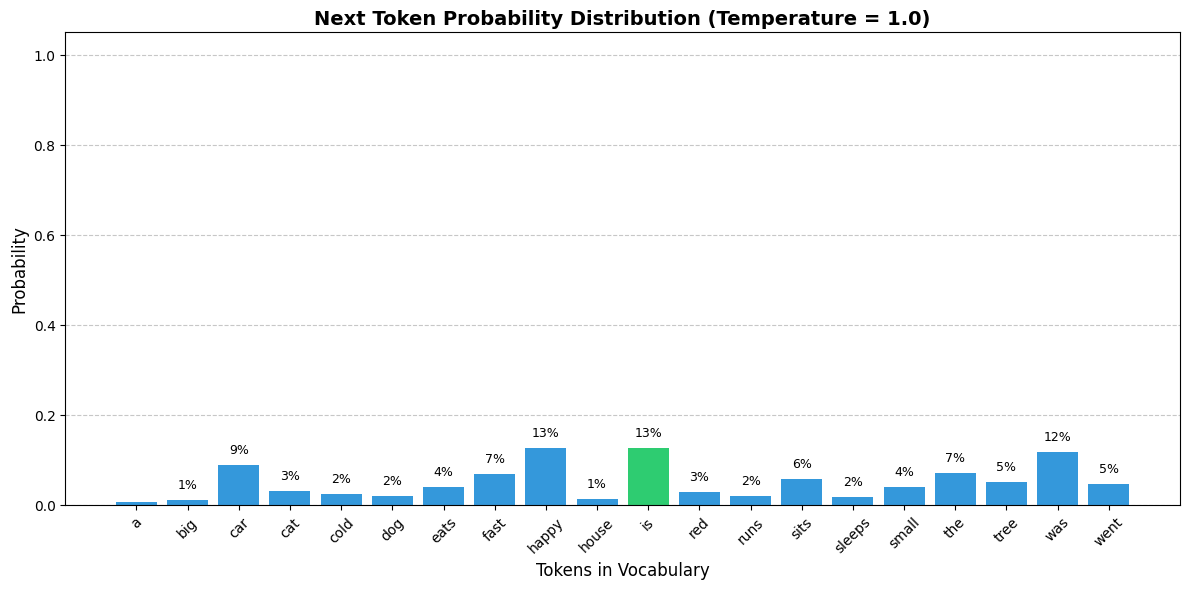

In [ ]:
# Try changing this value! (e.g., 0.1, 1.0, 5.0)
temperature = 1.0

print(f"\033[1m--- Applying Softmax with Temperature (T = {temperature}) ---\033[0m\n")
adj_logits = np.array(logits) / max(temperature, 1e-5)
adj_logits_2d = adj_logits.reshape(1, -1)
probabilities_2d = softmax(adj_logits_2d)
probabilities = probabilities_2d.flatten()
prob_word_pairs = list(zip(vocab, probabilities))
sorted_probs = sorted(prob_word_pairs, key=lambda x: x[1], reverse=True)

print("Top 3 Predictions by Probability:")
for idx, (word, prob) in enumerate(sorted_probs[:3]):
    if idx == 0:
        print(f"\033[92m1. '{word:<6}' -> {(prob * 100):>5.1f}%\033[0m")
    else:
        print(f"{idx+1}. '{word:<6}' -> {(prob * 100):>5.1f}%")

print("\n\033[1m--- Probability Distribution Across Vocabulary ---\033[0m")

plt.figure(figsize=(12, 6))

vocab_indices = np.argsort(vocab)
sorted_vocab_alphabetical = [vocab[i] for i in vocab_indices]
sorted_probs_alphabetical = [probabilities[i] for i in vocab_indices]
colors = ['#2ecc71' if p == max(probabilities) else '#3498db' for p in sorted_probs_alphabetical]
bars = plt.bar(sorted_vocab_alphabetical, sorted_probs_alphabetical, color=colors)
plt.title(f"Next Token Probability Distribution (Temperature = {temperature})", fontsize=14, fontweight='bold')
plt.xlabel("Tokens in Vocabulary", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.ylim(0, 1.05) 

for bar in bars:
    height = bar.get_height()
    if height > 0.01: 
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, 
                 f"{height*100:.0f}%", ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

## **Sampling the Next Token**

We have finally arrived at the end of the LLM pipeline! The probability distribution we just calculated is the **final mathematical output** of the Large Language Model. 

The LLM doesn't actually hand us a single token. It hands us a menu of *all possible tokens* in its vocabulary, each with a percentage representing the model's confidence in it being being the correct choice. 

To actually get our next token, we must **sample** from this distribution. 

#### **How Do We Sample?**

There are many ways to pick a token from this distribution. For simplicity, we will use a method called **Greedy Sampling**. 

Greedy sampling takes the token with the **highest probability**, ignoring all others. We are "greedy" because we always take the absolute best-scoring option every single time. 

Run this code to sample from our distribution, reveal our chosen token, and then append it to our original input sequence.

In [ ]:
print("\033[1m--- Greedy Sampling ---\033[0m\n")

best_token_index = np.argmax(probabilities)
best_probability = probabilities[best_token_index]
chosen_next_token = vocab[best_token_index]

print(f"The highest probability in our distribution is {best_probability * 100:.1f}%.")
print(f"This corresponds to index {best_token_index} in our vocabulary array.\n")

print("\033[1mOur LLM has selected the next token:\033[0m")
print(f"\n\033[1;92m==========  {chosen_next_token.upper()}  ==========\033[0m\n")

print("\033[1m--- The Final Sequence ---\033[0m\n")
original_sequence = [token_1, token_2]
final_sequence = original_sequence + [chosen_next_token]

print(f"Original Input: {original_sequence}")
print(f"New Sequence:   {final_sequence}\n")

print("And thus, the LLM has successfully generated the next word! In a real model, this entire process would repeat, taking our new 3-word sequence as the input to predict the 4th word, and so on.")

--- Greedy Sampling ---

The highest probability in our distribution is 12.7%.
This corresponds to index 9 in our vocabulary array.

Our LLM has selected the next token:

==========  IS  ==========

--- The Final Sequence ---

Original Input: ['a', 'car']
New Sequence:   ['a', 'car', 'is']

And thus, the LLM has successfully generated the next word! In a real model, this entire process would repeat, taking our new 3-word sequence as the input to predict the 4th word, and so on.


---

## **Training the Model**

Up until now, all the weights in our matrices were completely random. Because of this, the final 'prediction' we made wasn't based on any actual knowledge of language. So if it made no sense, that's expected.

Throughout this notebook, I have said "a learned weight matrix" many times. During training, we feed the model input text. It makes a prediction, compares its prediction to the actual next word in the text, and backpropagate the error signal to figure out how to adjust every parameter in the learned weight matrices so its prediction is slightly better next time.

Gradually, the random matrices organize themselves in a way that captures the statistical patterns of human language. 

To demonstrate this, we are going to build the exact model we just walked through and train it on text data I made from the words in the vocabulary list.

If this is your first time training a neural network, I am excited to introduce this to you. Run the cell below to train our network.

Early Stopping triggered at epoch 93!
Test loss has not improved for 5 consecutive epochs.
Best test loss was 2.2128. Restoring best weights...

Training Complete after 93 epochs!


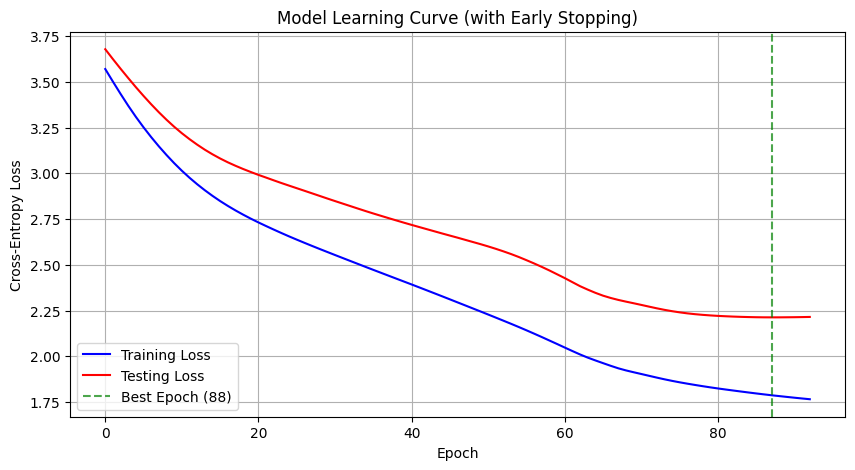

In [ ]:

# 1. Hyperparameters (Matching our manual walkthrough)

VOCAB = ['cat', 'is', 'happy', 'the', 'fast', 'dog', 'runs', 'a', 'tree', 'small', 'sits', 'car', 'went', 'big', 'sleeps', 'cold', 'red', 'house', 'was', 'eats']
VOCAB_SIZE = len(VOCAB)
EMBEDDING_DIM = 8
NUM_HEADS = 2
HEAD_DIM = 4
FFN_DIM = 24
NUM_LAYERS = 1

word_to_id = {word: i for i, word in enumerate(VOCAB)}
id_to_word = {i: word for i, word in enumerate(VOCAB)}

# 2. Defining the Architecture components
class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gain = nn.Parameter(torch.ones(dim)) # The Gain Vector!

    def forward(self, x):
        rms = torch.sqrt(torch.mean(x**2, dim=-1, keepdim=True) + 1e-6) # Calculate RMS: sqrt(mean(x^2))
        return (x / rms) * self.gain # Normalize and apply gain
def apply_rope(x):
    b, seq_len, h, d = x.shape  # x shape: (batch, seq_len, num_heads, head_dim)
    pos = torch.arange(seq_len, device=x.device).unsqueeze(1) # Generate position indices [0, 1]
    dim_indices = torch.arange(0, d, 2, device=x.device).float() # Generate frequencies for pairs of dimensions
    freqs = 1.0 / (10000 ** (dim_indices / d)) 
    angles = pos * freqs.unsqueeze(0) # Calculate angles: pos * freqs
    out = torch.zeros_like(x)
    for i in range(d // 2):
        x_i = x[..., 2*i]
        y_i = x[..., 2*i + 1]
        theta = angles[:, i].unsqueeze(0).unsqueeze(2) # Reshape for broadcasting
        out[..., 2*i] = x_i * torch.cos(theta) - y_i * torch.sin(theta)
        out[..., 2*i + 1] = x_i * torch.sin(theta) + y_i * torch.cos(theta)
    return out

class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.W_q = nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM, bias=False)
        self.W_k = nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM, bias=False)
        self.W_v = nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM, bias=False)
        self.W_o = nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM, bias=False)
        nn.init.normal_(self.W_q.weight, std=1.0/torch.sqrt(torch.tensor(EMBEDDING_DIM, dtype=torch.float)))
        nn.init.normal_(self.W_k.weight, std=1.0/torch.sqrt(torch.tensor(EMBEDDING_DIM, dtype=torch.float)))
        nn.init.normal_(self.W_v.weight, std=1.0/torch.sqrt(torch.tensor(EMBEDDING_DIM, dtype=torch.float)))
        nn.init.normal_(self.W_o.weight, std=1.0/torch.sqrt(torch.tensor(EMBEDDING_DIM, dtype=torch.float)))
        
    def forward(self, x):
        B, seq_len, _ = x.shape
        q = self.W_q(x).view(B, seq_len, NUM_HEADS, HEAD_DIM)
        k = self.W_k(x).view(B, seq_len, NUM_HEADS, HEAD_DIM)
        v = self.W_v(x).view(B, seq_len, NUM_HEADS, HEAD_DIM)
        q = apply_rope(q)
        k = apply_rope(k)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(HEAD_DIM, dtype=torch.float))
        mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(x.device)
        scores = scores + mask
        weights = F.softmax(scores, dim=-1)
        context = torch.matmul(weights, v)
        context = context.transpose(1, 2).contiguous().view(B, seq_len, EMBEDDING_DIM)
        output = self.W_o(context)
        return output

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.W_up = nn.Linear(EMBEDDING_DIM, FFN_DIM, bias=False)
        self.W_down = nn.Linear(FFN_DIM, EMBEDDING_DIM, bias=False)
        nn.init.normal_(self.W_up.weight, std=1.0/torch.sqrt(torch.tensor(EMBEDDING_DIM, dtype=torch.float)))
        nn.init.normal_(self.W_down.weight, std=1.0/torch.sqrt(torch.tensor(FFN_DIM, dtype=torch.float)))
    def forward(self, x):
        return self.W_down(F.relu(self.W_up(x)))

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm1 = RMSNorm(EMBEDDING_DIM)
        self.attn = Attention()
        self.norm2 = RMSNorm(EMBEDDING_DIM)
        self.ffn = FeedForward()
    def forward(self, x):
        # Residual Stream Integration
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

class MiniLLM(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.layers = nn.ModuleList([TransformerBlock() for _ in range(NUM_LAYERS)])
        self.final_norm = RMSNorm(EMBEDDING_DIM)
        self.vocab_matrix = nn.Linear(EMBEDDING_DIM, VOCAB_SIZE, bias=False)
        nn.init.normal_(self.vocab_matrix.weight, std=1.0/torch.sqrt(torch.tensor(EMBEDDING_DIM, dtype=torch.float)))
    def forward(self, x):
        x = self.token_embedding(x)
        for layer in self.layers:
            x = layer(x)
        x = self.final_norm(x)
        logits = self.vocab_matrix(x[:, -1, :]) 
        return logits

# 3. Data Loading and Preparation
print("Fetching dataset...")
url = "https://raw.githubusercontent.com/JPeggysus/How_LLMs_Work/main/training_data.jsonl"
req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
with urllib.request.urlopen(req) as response:
    raw_data = response.read().decode('utf-8').splitlines()

dataset = []
for line in raw_data:
    if line.strip():
        text = json.loads(line)['text']
        words = text.split()
        if len(words) == 3 and all(w in word_to_id for w in words):
            dataset.append([word_to_id[w] for w in words])

random.shuffle(dataset)
split_idx = int(len(dataset) * 0.9)
train_data = torch.tensor(dataset[:split_idx])
test_data = torch.tensor(dataset[split_idx:])

print(f"Loaded {len(dataset)} valid sequences. (Train: {len(train_data)} | Test: {len(test_data)})")

x_train, y_train = train_data[:, :2], train_data[:, 2]
x_test, y_test = test_data[:, :2], test_data[:, 2]

# 4. Training Loop
model = MiniLLM()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
MAX_EPOCHS = 200       # Upper limit so we don't run forever
PATIENCE = 5           # Stop after this many epochs with no test-loss improvement
train_losses = []
test_losses = []

best_test_loss = float('inf') # Early-stopping bookkeeping
epochs_without_improvement = 0
best_model_weights = None
print("\nStarting Training Loop with Early Stopping!")
print(f"(Max epochs: {MAX_EPOCHS} | Patience: {PATIENCE})\n")

sample_input_words = ['a', 'fast']
sample_input_ids = torch.tensor([[word_to_id[w] for w in sample_input_words]])

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    # Forward Pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    # Backward Pass (The magical calculus)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # Testing Loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        t_loss = criterion(test_outputs, y_test)
        test_losses.append(t_loss.item())
    # ---- Early Stopping Check ----
    if t_loss.item() < best_test_loss:
        best_test_loss = t_loss.item()
        epochs_without_improvement = 0
        # Save a snapshot of the best weights so far
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        epochs_without_improvement += 1
    # Visual Prediction 
    if epoch == 1 or epoch % 5 == 0:
        clear_output(wait=True)
        with torch.no_grad():
            sample_logits = model(sample_input_ids)
            pred_id = torch.argmax(sample_logits, dim=-1).item()
            pred_word = id_to_word[pred_id]
            
        print(f"Epoch {epoch}/{MAX_EPOCHS} (patience: {epochs_without_improvement}/{PATIENCE})")
        print(f"Training Loss: {loss.item():.4f} | Testing Loss: {t_loss.item():.4f} | Best: {best_test_loss:.4f}")
        print(f"Input: '{sample_input_words[0]} {sample_input_words[1]}' ")
        print(f"Model Predicts: -> '{pred_word}'\n")
        time.sleep(0.5)

    if epochs_without_improvement >= PATIENCE:
        clear_output(wait=True)
        print(f"\033[1mEarly Stopping triggered at epoch {epoch}!\033[0m")
        print(f"Test loss has not improved for {PATIENCE} consecutive epochs.")
        print(f"Best test loss was {best_test_loss:.4f}. Restoring best weights...\n")
        break

if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

print(f"Training Complete after {len(train_losses)} epochs!")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Testing Loss', color='red')
best_epoch = test_losses.index(min(test_losses)) + 1
plt.axvline(x=best_epoch - 1, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
plt.title("Model Learning Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

---

## **Running Inference**

Now that the model is trained we can use it to generate new text. This process of using a trained model to make predictions is called **Inference**. 

During inference, we don't adjust any weights or calculate any loss. We simply take an input sequence, convert it to token embeddings, run it through the trained model, and sample from the probability distribution.

#### **Test the Model!**

Let's see what our model has learned. Use the dropdowns below to choose a two-token input sequence, and let the model run inference to generate a prediction for the next word.

In [ ]:
print("\033[1m--- Interactive Inference ---\033[0m\n")

# Provide an interactive way to choose the two token input
inf_dropdown_1 = widgets.Dropdown(options=VOCAB, value='a', description='Token 1:')
inf_dropdown_2 = widgets.Dropdown(options=VOCAB, value='fast', description='Token 2:')

# Use an HTML widget instead of Output widget to avoid clear_output batching issues.
# Setting .value on an HTML widget atomically replaces the content every time.
inf_html = widgets.HTML(value='')

def run_inference(change):
    global model
    t1 = inf_dropdown_1.value
    t2 = inf_dropdown_2.value
    
    # 1. Convert words to Token IDs
    input_ids = torch.tensor([[word_to_id[t1], word_to_id[t2]]])
    
    # 2. Run the forward pass (Inference)
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # We don't need to track gradients for inference!
        logits = model(input_ids)
        
        # The model outputs logits for the final token's position
        # 3. Greedy Sampling: Get the highest probability token
        pred_id = torch.argmax(logits, dim=-1).item()
        pred_word = id_to_word[pred_id]
        
    # 4. Build the full generated sequence
    full_seq = [t1, t2, pred_word]
    
    # Update the HTML widget content (atomic replacement, no duplication possible)
    inf_html.value = (
        f"<pre>"
        f"Your Input Sequence: ['{t1}', '{t2}']\n\n"
        f"<b>Model Predicts Next Token:</b>\n\n"
        f"<span style='color:#2ecc71; font-weight:bold'>==========  {pred_word.upper()}  ==========</span>\n\n"
        f"<b>Full Generated Sequence:</b> {full_seq}\n"
        f"</pre>"
    )

inf_dropdown_1.observe(run_inference, names='value')
inf_dropdown_2.observe(run_inference, names='value')

display(inf_dropdown_1, inf_dropdown_2, inf_html)

# Run once initially to display a prediction
run_inference(None)

---
## **You Just Made a Working LLM**

As you can see, the model's next token predictions now actually match the input sequences you give it.

What we have explored in this notebook is exactly how LLMs work. Every advancement in this technology has been built on top of this setup. The math is the same. The architecture is the same or similar. The only things now separating you and the cutting-edge labs are massive proprietary datasets, thousands of GPUs of compute, and a billionaire with a god complex. I'll leave it up to you to secure these on your own.

I intend to create a pt.2 soon focused solely on training.

**If you have feedback or want to connect, please reach out:** 
https://www.linkedin.com/in/jakepegurri/ or jakepegurri@gmail.com